In [0]:
# First off - load all python libraries we are going to need
import pandas as pd
import numpy as np
import os
#import plotly.plotly as py
#import plotly.graph_objs as go


from google.colab import auth
from google.cloud import bigquery
from google.colab import files

import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
from matplotlib.pyplot import figure


from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import RidgeClassifier
!pip install regressors
from regressors import stats    


from sklearn.impute import SimpleImputer

from sklearn import metrics

import statsmodels.api as sm

# !pip install pygam
# from pygam import GAM, s, l , te ,LogisticGAM, LinearGAM

from patsy import dmatrices

import seaborn as sns
%matplotlib inline

# !pip install zepid
# import zepid as zp

#import plotly
#plotly.tools.set_credentials_file(username='harounchahed', api_key='ZHypTc119csyz5p0xWet')

  Created wheel for regressors: filename=regressors-0.0.3-py2.py3-none-any.whl size=12374 sha256=a405635c261fe9787fc442670cae47de2ab6d82cb6e2f146561bc5e4d5653c37
  Stored in directory: /root/.cache/pip/wheels/b2/89/fc/7867f77234d0033395f7ad9814f245b337139acaa06b085aa2
Successfully built regressors


In [0]:
auth.authenticate_user() #This will allow you to authenticate access to BigQuery4/rwDcMzFm8oGoxefjkisvhYNHOGbb11AmM1WbgDorhC0DBQNExxFg1yI

In [0]:
#This is a method that executes a desired SQL query on the database
project_id='ync-capstones'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id
# Read data from BigQuery into pandas dataframes.
def run_query(query):
  return pd.io.gbq.read_gbq(query, project_id=project_id, verbose=False, configuration={'query':{'useLegacySql': False}})

In [0]:
# Now load the data. In general you'd load the whole set of notes but that would take
# several minutes so for this example we're just going to use a subset
#notes = pd.read_csv('D.csv')
cohort = run_query('''
    select * 
    from `NMB.COHORT_BASELINE_P2`
    ''')

SF_raw = run_query('''
    select * 
    from `NMB.TIME_DEP_SF`
    ''')

Treamtment_raw = run_query('''
    select * 
    from `NMB.TIME_DEP_TR`
    ''')

/usr/local/lib/python3.6/dist-packages/pandas/io/gbq.py:176: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs


# Data Cleaning

## Cohort

In [0]:
cohort = cohort.set_index(['subject_id',	'hadm_id',	'icustay_id'], drop = True)

In [0]:
cohort.mv_starttime = pd.to_datetime(cohort.mv_starttime)
cohort.mv_endtime = pd.to_datetime(cohort.mv_endtime)
cohort.dod = pd.to_datetime(cohort.dod)

In [0]:
cohort

,,,mv_durations_hours,mv_starttime,mv_endtime,min_pao2fio2,max_peep,age,dod,los,weight,height,BMI,admission_type,admission_location,LANGUAGE,religion,marital_status,ethnicity,diagnosis,female,oasis,elixhauser,explicit_sepsis,vaso
subject_id,hadm_id,icustay_id,,,,,,,,,,,,,,,,,,,,,,,
10852,139654,253340,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.10,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0
27172,183106,209167,155.00000,2111-09-06 01:00:00,2111-09-12 12:00:00,76.25000,12.0,55.0,NaT,16.8144,NaN,177.80,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,MARRIED,WHITE,PNEUMONIA,0,54,17,1,1
42071,186278,266722,24.50000,2117-08-05 16:00:00,2117-08-06 16:30:00,101.66667,10.0,46.0,NaT,6.3212,85.30,180.00,26.3,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,ENGL,CATHOLIC,MARRIED,PATIENT DECLINED TO ANSWER,STATUS POST CARDIAC ARREST\CARDIAC CATHETERIZA...,0,34,0,0,0
48925,127507,260855,183.66667,2129-01-22 16:20:00,2129-01-30 08:00:00,71.00000,18.0,68.0,NaT,19.2946,113.40,NaN,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,ENGL,NOT SPECIFIED,MARRIED,WHITE,SKULL FRACTURE; HEAD BLEED,0,51,13,0,1
51443,195487,214313,153.25000,2124-03-06 08:00:00,2124-03-12 16:15:00,110.00000,15.0,57.0,2124-11-07,16.8966,201.85,177.80,63.9,EMERGENCY,EMERGENCY ROOM ADMIT,ENGL,NOT SPECIFIED,SINGLE,WHITE,ALTERED MENTAL STATUS,0,38,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42860,160594,219786,5.48333,2113-01-23 19:00:00,2113-01-24 00:29:00,79.00000,5.0,62.0,NaT,1.2864,88.40,180.00,27.3,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,PROTESTANT QUAKER,SINGLE,BLACK/AFRICAN AMERICAN,MITRAL VALVE STENOSIS; SHORTNESS OF BREATH\LEF...,0,33,0,0,1
6025,184173,233970,5.86667,2109-12-13 12:00:00,2109-12-13 17:52:00,138.33333,5.0,83.0,NaT,12.4215,53.00,152.40,22.8,EMERGENCY,EMERGENCY ROOM ADMIT,None,CATHOLIC,None,WHITE,PERFORATED VISCUS,1,52,12,0,1
14858,191758,211210,6.00000,2133-04-10 14:00:00,2133-04-10 20:00:00,123.00000,5.0,70.0,NaT,1.8278,81.60,157.48,32.9,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,None,CATHOLIC,SINGLE,WHITE,UNSTABLE ANGINA,1,51,0,0,1


In [0]:
cohort.shape # number of patiens
# Sanity check: cohort.groupby(['subject_id', 'hadm_id','icustay_id']).size().count() 

(3820, 23)

In [0]:
# This code fixes few ages that are assigned an age >300 by mistake. We replace these ages with the average age of the dataset.
cohort.loc[cohort.age >= 300, 'age'] = 89

/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


In [0]:
# this code fixes removes unrealistic PEEP values 
cohort = cohort.drop(cohort[cohort.max_peep > 50].index)

In [0]:
cohort["mortality"] = np.where(cohort.dod.notnull(), 1 , 0)

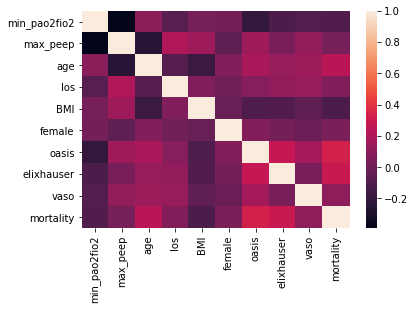

In [0]:
for_cov = cohort[[	"min_pao2fio2",	"max_peep",	"age"	, "los"	, 
                      "BMI"	, "admission_type"	, "admission_location",	
                      "religion" ,	"marital_status",	"ethnicity",	"diagnosis"	,	"female"	, "oasis",
                      "elixhauser",	"vaso",	"mortality"]]
corr = for_cov.corr()
corr_fig = sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
#corr_fig.figure.savefig("corr_fig.pdf", bbox_inches='tight', dpi=300)
#files.download("corr_fig.pdf") 

In [0]:
# Dataframe containing only severity and comorbidity scores.
illness = cohort[['oasis', 'elixhauser']]

# Correlation coefficients 
illness.corr()

,oasis,elixhauser
oasis,1.000000,0.277414
elixhauser,0.277414,1.000000


## SF ratios

In [0]:
SF_raw.mv_starttime = pd.to_datetime(SF_raw.mv_starttime)
SF_raw.mv_endtime = pd.to_datetime(SF_raw.mv_endtime)
SF_raw.sf_charttime = pd.to_datetime(SF_raw.sf_charttime)

In [0]:
SF_raw

,subject_id,hadm_id,icustay_id,mv_durations_hours,mv_starttime,mv_endtime,SF_ratio,sf_charttime
0,9,150750,220597,118.33333,2149-11-09 18:40:00,2149-11-14 17:00:00,1.840,2149-11-12 09:00:00
1,9,150750,220597,118.33333,2149-11-09 18:40:00,2149-11-14 17:00:00,1.980,2149-11-11 09:00:00
2,9,150750,220597,118.33333,2149-11-09 18:40:00,2149-11-14 17:00:00,1.940,2149-11-12 12:00:00
3,9,150750,220597,118.33333,2149-11-09 18:40:00,2149-11-14 17:00:00,1.840,2149-11-12 08:00:00
4,9,150750,220597,118.33333,2149-11-09 18:40:00,2149-11-14 17:00:00,1.800,2149-11-12 08:00:00
...,...,...,...,...,...,...,...,...
148623,99985,176670,279638,216.76667,2181-01-29 13:14:00,2181-02-07 14:00:00,1.980,2181-02-01 05:00:00
148624,99985,176670,279638,216.76667,2181-01-29 13:14:00,2181-02-07 14:00:00,2.425,2181-02-05 19:00:00
148625,99985,176670,279638,216.76667,2181-01-29 13:14:00,2181-02-07 14:00:00,1.940,2181-01-31 16:00:00
148626,99985,176670,279638,216.76667,2181-01-29 13:14:00,2181-02-07 14:00:00,1.980,2181-02-03 04:00:00


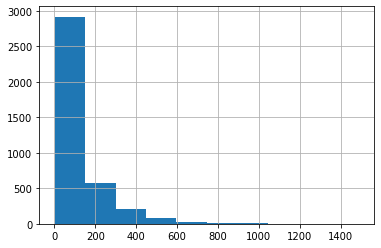

In [0]:
cohort.mv_durations_hours.hist()

In [0]:
SF_raw.subject_id.count() # of SF ratio observations taken within the mechanical ventilation period of our patie

148628

In [0]:
SF_raw.groupby(['subject_id', 'hadm_id','icustay_id']).size().count() # 3748 of 3820 have at least one SF ratio measured

3748

### Treatment

In [0]:
Treamtment_raw.mv_starttime = pd.to_datetime(Treamtment_raw.mv_starttime)
Treamtment_raw.mv_endtime = pd.to_datetime(Treamtment_raw.mv_endtime)
Treamtment_raw.NMBA_timestamp = pd.to_datetime(Treamtment_raw.NMBA_timestamp)

In [0]:
Treamtment_raw.head()

,subject_id,hadm_id,icustay_id,mv_durations_hours,mv_starttime,mv_endtime,NMBA_amount,NMBA_timestamp
0,213,179315,253210,161.25,2122-02-13 15:45:00,2122-02-20 09:00:00,4.701333,2122-02-15 03:40:00
1,213,179315,253210,161.25,2122-02-13 15:45:00,2122-02-20 09:00:00,0.000000,2122-02-15 05:00:00
2,213,179315,253210,161.25,2122-02-13 15:45:00,2122-02-20 09:00:00,NaN,2122-02-15 03:00:00
3,213,179315,253210,161.25,2122-02-13 15:45:00,2122-02-20 09:00:00,NaN,2122-02-15 03:40:00
4,213,179315,253210,161.25,2122-02-13 15:45:00,2122-02-20 09:00:00,7.052000,2122-02-15 03:00:00


In [0]:
Treamtment_raw.icustay_id.count() # of NMBA doses givent within the mechanical ventilation period of our patients

37603

In [0]:
Treamtment_raw.groupby(['subject_id', 'hadm_id','icustay_id']).size().count() # 468 have been given NMBAS

468

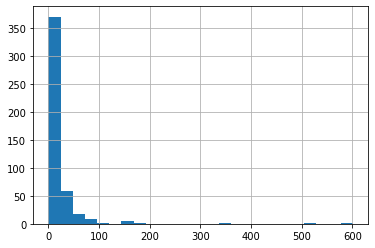

In [0]:
tr_grouped = Treamtment_raw.groupby(['subject_id', 'hadm_id','icustay_id']).size()
freq_of_TR = np.array(tr_grouped) / cohort.mv_durations_hours.loc[tr_grouped.index].divide(24) 
freq_of_TR.hist(bins = 25)

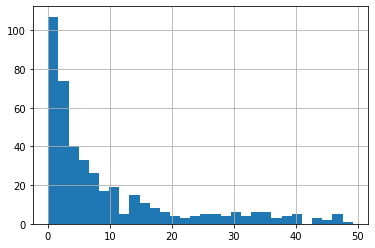

In [0]:
freq_of_TR[freq_of_TR < 50].hist(bins = 30)

In [0]:
freq_of_TR[freq_of_TR < 1].count() # number of people who are treated less than once a day

67

# IPTW

Example of patient who took drug

In [0]:
this_index = (250	,124271	,205951)

In [0]:
# initialize empty dataFrame
  # index
dates_index = pd.date_range(start=cohort.mv_starttime.loc[this_index],
              end = cohort.mv_endtime.loc[this_index],
              freq = 'H' )
  # DataFrame
date = pd.DataFrame(index = pd.Index(dates_index, name = 'MV_date'))
  # Columns
# date['ID'] = np.full(len(dates_index), this_index)
date['subject_id'] = np.full(len(dates_index), this_index[0])
date['hadm_id'] = np.full(len(dates_index), this_index[1])
date['icustay_id'] = np.full(len(dates_index), this_index[2])
date['SF_ratio'] = np.nan
date['tr_t_min_1'] = np.zeros(len(dates_index))
date['tr_t'] = np.zeros(len(dates_index))
date['death_t'] = np.zeros(len(dates_index))

In [0]:
# fill the SF ratios
for index ,row  in SF_raw.loc[SF_raw.icustay_id== this_index[2]].iterrows():
  SF_date = row.sf_charttime
  if SF_date in dates_index:
    if pd.isnull(date.loc[SF_date, 'SF_ratio']): # check that it is null
        date.loc[SF_date, 'SF_ratio'] = row.SF_ratio
    elif date.loc[SF_date, 'SF_ratio'] > row.SF_ratio:
        date.loc[SF_date, 'SF_ratio'] = row.SF_ratio

In [0]:
# fill the treatment history 
for index ,row  in Treamtment_raw.loc[Treamtment_raw.icustay_id== this_index[2]].iterrows():
  tr_date = row.NMBA_timestamp.floor('h')
  if tr_date in dates_index: 
    date.loc[tr_date, 'tr_t'] = 1
    next_hour = (tr_date + pd.DateOffset(hours=1))
    if next_hour in dates_index:
      date.loc[next_hour, 'tr_t_min_1'] = 1

In [0]:
# Fill in death date 
if pd.notnull(cohort.loc[this_index].dod.date()): 
  # print(cohort.loc[this_index].dod)
  if cohort.loc[this_index].dod.floor('h') in dates_index:
    date.loc[cohort.loc[this_index].dod.floor('h'), 'death_t'] = 1

In [0]:
date

,subject_id,hadm_id,icustay_id,SF_ratio,tr_t_min_1,tr_t,death_t
MV_date,,,,,,,
2188-11-12 21:00:00,250,124271,205951,NaN,0.0,0.0,0.0
2188-11-12 22:00:00,250,124271,205951,NaN,0.0,0.0,0.0
2188-11-12 23:00:00,250,124271,205951,NaN,0.0,0.0,0.0
2188-11-13 00:00:00,250,124271,205951,NaN,0.0,0.0,0.0
2188-11-13 01:00:00,250,124271,205951,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2188-11-22 18:00:00,250,124271,205951,NaN,1.0,1.0,0.0
2188-11-22 19:00:00,250,124271,205951,NaN,1.0,1.0,0.0
2188-11-22 20:00:00,250,124271,205951,NaN,1.0,0.0,0.0


# Exposure Model

In [0]:
def reformat(this_index, SF_raw, Treamtment_raw):
  # initialize empty dataFrame
    # index
  dates_index = pd.date_range(start=cohort.mv_starttime.loc[this_index],
                end = cohort.mv_endtime.loc[this_index],
                freq = 'H' )
    # DataFrame
  date = pd.DataFrame(index = pd.Index(dates_index, name = 'MV_date'))
    # Columns
  # date['ID'] = np.full(len(dates_index), this_index)
  date['subject_id'] = np.full(len(dates_index), this_index[0])
  date['hadm_id'] = np.full(len(dates_index), this_index[1])
  date['icustay_id'] = np.full(len(dates_index), this_index[2])
  date['SF_ratio'] = np.nan
  date['tr_t_min_1'] = np.zeros(len(dates_index))
  date['tr_t'] = np.zeros(len(dates_index))
  date['death_t'] = np.zeros(len(dates_index))

  # fill the SF ratios
  for index ,row  in SF_raw.loc[SF_raw.icustay_id== this_index[2]].iterrows():
    SF_date = row.sf_charttime
    if SF_date in dates_index:
      if pd.isnull(date.loc[SF_date, 'SF_ratio']): # check that it is null
          date.loc[SF_date, 'SF_ratio'] = row.SF_ratio
      # elif date.loc[SF_date, 'SF_ratio'] > row.SF_ratio:
      #     date.loc[SF_date, 'SF_ratio'] = row.SF_ratio
      
  # fill the treatment history 
  for index ,row  in Treamtment_raw.loc[Treamtment_raw.icustay_id== this_index[2]].iterrows():
    tr_date = row.NMBA_timestamp.floor('h')
    if tr_date in dates_index: 
      date.loc[tr_date, 'tr_t'] = 1
      next_hour = (tr_date + pd.DateOffset(hours=1))
      if next_hour in dates_index:
        date.loc[next_hour, 'tr_t_min_1'] = 1

  # Fill in death date 
  if pd.notnull(cohort.loc[this_index].dod.date()): 
    # print(cohort.loc[this_index].dod)
    if cohort.loc[this_index].dod.floor('h') in dates_index:
      date.loc[cohort.loc[this_index].dod.floor('h'), 'death_t'] = 1
  return date

In [0]:
PMF_table = pd.DataFrame(columns = ['subject_id', 'hadm_id', 'icustay_id', 'SF_ratio', 'tr_t_min_1', 'tr_t', 'death_t'])
PMF_table.index.name = 'MV_date'

for index in cohort.index: 
  PMF_concat = reformat(index, SF_raw, Treamtment_raw)
  PMF_table = pd.concat([PMF_table, PMF_concat])

In [0]:
PMF_table.shape

(418048, 7)

In [0]:
MSM_table = PMF_table[PMF_table.SF_ratio.notnull()] 
MSM_table = MSM_table.merge(cohort, how = 'left' , on = ['subject_id', 'hadm_id', 'icustay_id'])
MSM_table

,subject_id,hadm_id,icustay_id,SF_ratio,tr_t_min_1,tr_t,death_t,mv_durations_hours,mv_starttime,mv_endtime,min_pao2fio2,max_peep,age,dod,los,weight,height,BMI,admission_type,admission_location,LANGUAGE,religion,marital_status,ethnicity,diagnosis,female,oasis,elixhauser,explicit_sepsis,vaso,mortality
0,10852,139654,253340,1.371429,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0
1,10852,139654,253340,1.900000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0
2,10852,139654,253340,1.920000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0
3,10852,139654,253340,2.450000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0
4,10852,139654,253340,2.400000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75891,6025,184173,233970,2.425000,0.0,0.0,0.0,5.86667,2109-12-13 12:00:00,2109-12-13 17:52:00,138.33333,5.0,83.0,NaT,12.4215,53.0,152.40,22.8,EMERGENCY,EMERGENCY ROOM ADMIT,None,CATHOLIC,None,WHITE,PERFORATED VISCUS,1,52,12,0,1,0
75892,14858,191758,211210,2.000000,0.0,0.0,0.0,6.00000,2133-04-10 14:00:00,2133-04-10 20:00:00,123.00000,5.0,70.0,NaT,1.8278,81.6,157.48,32.9,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,None,CATHOLIC,SINGLE,WHITE,UNSTABLE ANGINA,1,51,0,0,1,0
75893,14858,191758,211210,1.900000,0.0,0.0,0.0,6.00000,2133-04-10 14:00:00,2133-04-10 20:00:00,123.00000,5.0,70.0,NaT,1.8278,81.6,157.48,32.9,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,None,CATHOLIC,SINGLE,WHITE,UNSTABLE ANGINA,1,51,0,0,1,0
75894,84717,134774,234116,2.250000,0.0,0.0,0.0,2.00000,2104-09-21 05:00:00,2104-09-21 07:00:00,76.00000,5.0,77.0,2104-09-22,2.1108,41.3,NaN,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,MARRIED,WHITE,SEPSIS,1,52,10,1,1,1


In [0]:
#PMF_table_full = PMF_table_full.groupby(['subject_id',	'hadm_id',	'icustay_id']).tail(24) # remember to delete this if it doesn't work!!!!!

In [0]:
y, X = dmatrices('tr_t ~  SF_ratio + tr_t_min_1', data=MSM_table, return_type='dataframe')
# y, X = dmatrices('tr_t ~  pao2fio2', data=PF_table_full, return_type='dataframe')
logit_model_den = sm.Logit(y,X)
fitted_model_den=logit_model_den.fit()
print(fitted_model_den.summary())

Optimization terminated successfully.
         Current function value: 0.051636
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   tr_t   No. Observations:                75896
Model:                          Logit   Df Residuals:                    75893
Method:                           MLE   Df Model:                            2
Date:                Thu, 19 Mar 2020   Pseudo R-squ.:                  0.6491
Time:                        09:39:20   Log-Likelihood:                -3919.0
converged:                       True   LL-Null:                       -11170.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.0570      0.161    -12.767      0.000      -2.373      -1.741
SF_ratio      -1.5707      0.

In [0]:
y, X = dmatrices('tr_t ~ tr_t_min_1 + age + female + oasis + elixhauser + explicit_sepsis + vaso', data = MSM_table, return_type='dataframe')
logit_model_nom = sm.Logit(y,X)
fitted_model_nom = logit_model_nom.fit()
print(fitted_model_nom.summary())

Optimization terminated successfully.
         Current function value: 0.052800
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   tr_t   No. Observations:                75896
Model:                          Logit   Df Residuals:                    75888
Method:                           MLE   Df Model:                            7
Date:                Thu, 19 Mar 2020   Pseudo R-squ.:                  0.6412
Time:                        09:39:21   Log-Likelihood:                -4007.3
converged:                       True   LL-Null:                       -11170.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -4.4177      0.216    -20.477      0.000      -4.841      -3.995
tr_t_min_1    

In [0]:
MSM_table["den"] = np.nan
MSM_table["nom"] = np.nan

In [0]:
cols = MSM_table.columns
BC = ['tr_t_min_1', 'age', 'female', 'oasis', 'elixhauser', 'explicit_sepsis', 'vaso']
TDC = ['SF_ratio', 'tr_t_min_1']
patient_id = ['subject_id', 'hadmi_id', 'icustay_id']
BC_index = [MSM_table.columns.get_loc(c) for c in cols if c in BC]
TDC_index = [MSM_table.columns.get_loc(c) for c in cols if c in TDC]
patient_id_index = [MSM_table.columns.get_loc(c) for c in cols if c in patient_id]

In [0]:
den_index = MSM_table.columns.get_loc("den")
nom_index = MSM_table.columns.get_loc("nom")
trt_index = MSM_table.columns.get_loc("tr_t")

In [0]:
for i in range(len(MSM_table)):
  if i == 0: 
    BC_prob = fitted_model_nom.predict([1] + list(MSM_table.iloc[i, BC_index]))[0] #This is for the first row
    TDC_prob = fitted_model_den.predict([1] + list(MSM_table.iloc[i, TDC_index]))[0] #This is for the first row
    if MSM_table.iloc[i, trt_index] == 1: # if treated
      MSM_table.iloc[i, nom_index] = BC_prob # get probability treatment
      MSM_table.iloc[i, den_index] = TDC_prob # get probability treatment
    else:  # if not treated
      MSM_table.iloc[i, nom_index] = 1 - BC_prob # get probability treatment
      MSM_table.iloc[i, den_index] = 1 - TDC_prob # get probability treatment  
  else: # if not first row
    if (MSM_table.iloc[i, patient_id_index] == MSM_table.iloc[i - 1, patient_id_index]).all(): # if same patient as previous row 
      sing_BC_prob = fitted_model_nom.predict([1] + list(MSM_table.iloc[i, BC_index]))[0] 
      sing_TDC_prob = fitted_model_den.predict([1] + list(MSM_table.iloc[i, TDC_index]))[0] 
      if MSM_table.iloc[i, trt_index] == 1: # if treated
        MSM_table.iloc[i, nom_index] = sing_BC_prob * MSM_table.iloc[i-1, nom_index] # get probability treatment multiplied by previous day treatment probability
        MSM_table.iloc[i, den_index] = sing_TDC_prob * MSM_table.iloc[i-1, den_index] # get probability treatment multiplied by previous day treatment probability
      else:  # if not treated
        MSM_table.iloc[i, nom_index] = (1 - sing_BC_prob) * MSM_table.iloc[i-1, nom_index] # get probability non-treatment multiplied by previous day treatment probability
        MSM_table.iloc[i, den_index] = (1 - sing_TDC_prob) * MSM_table.iloc[i-1, den_index] # get probability non-treatment multiplied by previous day treatment probability
    else: # if not same patient
      BC_prob = fitted_model_nom.predict([1] + list(MSM_table.iloc[i, BC_index]))[0] #This is for the first row
      TDC_prob = fitted_model_den.predict([1] + list(MSM_table.iloc[i, TDC_index]))[0] #This is for the first row
      if MSM_table.iloc[i, trt_index] == 1: # if treated
        MSM_table.iloc[i, nom_index] = BC_prob # get probability treatment
        MSM_table.iloc[i, den_index] = TDC_prob # get probability treatment
      else:  # if not treated
        MSM_table.iloc[i, nom_index] = 1 - BC_prob # get probability treatment
        MSM_table.iloc[i, den_index] = 1 - TDC_prob # get probability treatment  

In [0]:
MSM_table['IPTW'] = MSM_table.nom / MSM_table.den

## IPTW sensitivity analysis

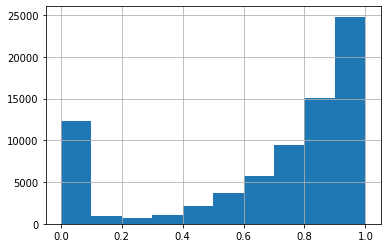

In [0]:
MSM_table.den.hist()

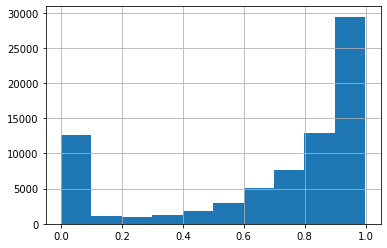

In [0]:
MSM_table.nom.hist()

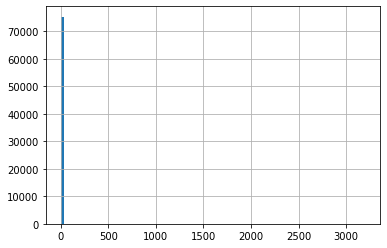

In [0]:
MSM_table.IPTW.hist(bins =100) #75896

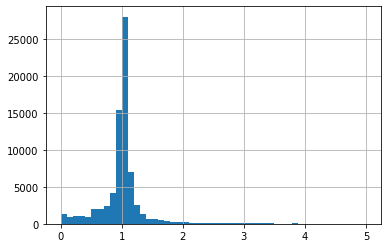

In [0]:
MSM_table # 75896 rows
MSM_table[MSM_table.IPTW < 5].IPTW.hist(bins=50) #74722

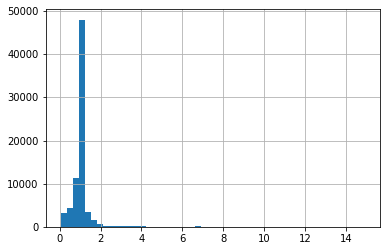

In [0]:
# truncate top 1% and bottom 99% of weights 
MSM_table_trunc = MSM_table[(MSM_table.IPTW < MSM_table.IPTW.quantile(.99)) & (MSM_table.IPTW > MSM_table.IPTW.quantile(.01))]
MSM_table_trunc.IPTW.hist(bins = 50)

{'boxes': [<matplotlib.lines.Line2D at 0x7f8bb86857b8>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8bb868d4a8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8bb8694160>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8bb868dc88>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8bb8685b70>,
  <matplotlib.lines.Line2D at 0x7f8bb868d080>]}

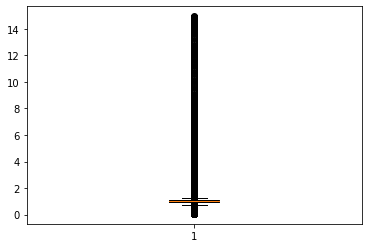

In [0]:
plt.boxplot(MSM_table_trunc.IPTW)

In [0]:
# highest_weight_patient = MSM_table[MSM_table.IPTW == max(MSM_table.IPTW)].subject_id # subject with highest weight
# MSM_table[MSM_table.subject_id == int(highest_weight_patient)]

In [0]:
MSM_table_trunc.IPTW.mean()

1.070301783948852

## Effect of PF ratio frequency


{'boxes': [<matplotlib.lines.Line2D at 0x7f8bbc7d6a58>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8bbc8027b8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8bbc7cb780>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8bbc8a4a20>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8bbc7d6f98>,
  <matplotlib.lines.Line2D at 0x7f8bbc802160>]}

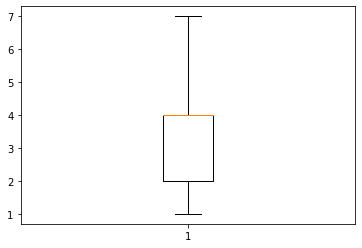

In [0]:
dates = PMF_table[pd.notnull(PMF_table.SF_ratio)].index
diff = dates[1:] - dates[:-1]
diff_hours =diff/np.timedelta64(1,'h')
real_diff_hours = diff_hours[np.abs(diff_hours) < 8] # 75895 - 72434 < 3820
plt.boxplot(real_diff_hours)

(array([    0.,  9135.,  9985., 13658., 29713.,  8321.,  1207.,   415.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5]),
 <a list of 8 Patch objects>)

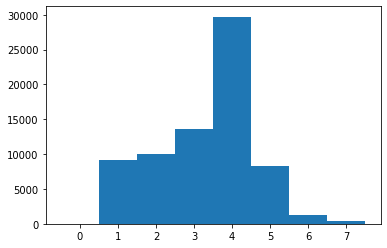

In [0]:
bins = np.arange(0, real_diff_hours.max() + 1.5) - 0.5
plt.hist(real_diff_hours, bins = bins)

# Structural Model

### 1h and 0%

{'boxes': [<matplotlib.lines.Line2D at 0x7f8baf2dda90>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8baf2e64e0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8baf2e6f60>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8baf2e6be0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8baf2ddda0>,
  <matplotlib.lines.Line2D at 0x7f8baf2e6160>]}

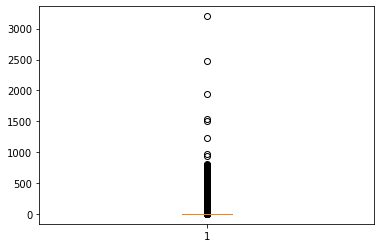

In [0]:
plt.boxplot(MSM_table.IPTW)

In [0]:
MSM_table.IPTW.mean()

3.698426530027305

In [0]:
X = MSM_table[['tr_t_min_1', 'age', 'female', 	'oasis',	'elixhauser',	'explicit_sepsis',	'vaso']]
y = MSM_table['death_t']

# Instantiate a binomial family model with the logit function.
MSM_model = sm.GLM(y, X, family = sm.families.Binomial(), links = sm.genmod.families.links.logit, freq_weights=MSM_table.IPTW.astype(np.float64))
# MSM_model = sm.GLM(y, X, links = sm.genmod.families.links.logit, freq_weights = MSM_table.IPTW.astype(np.float64))

MSM_result = MSM_model.fit()

print(MSM_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death_t   No. Observations:                75896
Model:                            GLM   Df Residuals:                280688.78
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1648.3
Date:                Thu, 19 Mar 2020   Deviance:                       3296.5
Time:                        16:17:28   Pearson chi2:                 8.89e+05
No. Iterations:                    13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
tr_t_min_1         -3.1640      0.914     

### 1h and 1%

{'boxes': [<matplotlib.lines.Line2D at 0x7f8bb82d9128>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8bb8392c18>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8bb83341d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8bb82246d8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8bb83ff400>,
  <matplotlib.lines.Line2D at 0x7f8bb831c160>]}

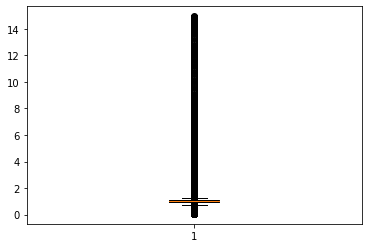

In [0]:
plt.boxplot(MSM_table_trunc.IPTW)

In [0]:
MSM_table_trunc.IPTW.mean()

1.070301783948852

In [0]:
# truncate top 1% and bottom 99% of weights 
MSM_table_trunc = MSM_table[(MSM_table.IPTW < MSM_table.IPTW.quantile(.99)) & (MSM_table.IPTW > MSM_table.IPTW.quantile(.01))]

In [0]:
X = MSM_table_trunc[['tr_t_min_1', 'age', 'female', 	'oasis',	'elixhauser',	'explicit_sepsis',	'vaso']]
y = MSM_table_trunc['death_t']

# Instantiate a binomial family model with the logit function.
MSM_model = sm.GLM(y, X, family = sm.families.Binomial(), links = sm.genmod.families.links.logit, freq_weights=MSM_table_trunc.IPTW.astype(np.float64))
# MSM_model = sm.GLM(y, X, links = sm.genmod.families.links.logit, freq_weights = MSM_table.IPTW.astype(np.float64))

MSM_result = MSM_model.fit()

print(MSM_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death_t   No. Observations:                74378
Model:                            GLM   Df Residuals:                 79599.91
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1474.3
Date:                Thu, 19 Mar 2020   Deviance:                       2948.6
Time:                        09:43:55   Pearson chi2:                 2.57e+05
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
tr_t_min_1         -2.3047      0.912     

### 1h and 2%

{'boxes': [<matplotlib.lines.Line2D at 0x7f8bb7e8c588>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8bb7d5fef0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8bb7d960b8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8bb7d8b128>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8bb7e37f28>,
  <matplotlib.lines.Line2D at 0x7f8bb7dc99e8>]}

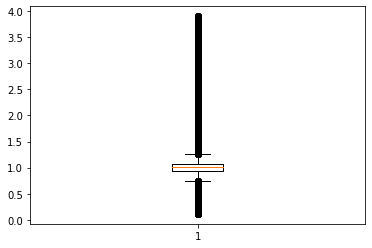

In [0]:
plt.boxplot(MSM_table_trunc_2.IPTW)

In [0]:
MSM_table_trunc_2.IPTW.mean()

1.013995541135072

In [0]:
# truncate top 2% and bottom 2% of weights 
MSM_table_trunc_2 = MSM_table[(MSM_table.IPTW < MSM_table.IPTW.quantile(.98)) & (MSM_table.IPTW > MSM_table.IPTW.quantile(.02))]

In [0]:
X = MSM_table_trunc_2[['tr_t_min_1', 'age', 'female', 	'oasis',	'elixhauser',	'explicit_sepsis', 'vaso']] # add sepsis and BMI
y = MSM_table_trunc_2['death_t']

# Instantiate a binomial family model with the logit function.
MSM_model = sm.GLM(y, X, family = sm.families.Binomial(), links = sm.genmod.families.links.logit, freq_weights=MSM_table_trunc_2.IPTW.astype(np.float64))
# MSM_model = sm.GLM(y, X, links = sm.genmod.families.links.logit, freq_weights = MSM_table.IPTW.astype(np.float64))

MSM_result = MSM_model.fit()

print(MSM_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death_t   No. Observations:                72860
Model:                            GLM   Df Residuals:                 73872.72
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1338.9
Date:                Thu, 19 Mar 2020   Deviance:                       2677.8
Time:                        16:22:46   Pearson chi2:                 2.52e+05
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
tr_t_min_1         -1.7386      0.912     

## 2h

### 2h and 0%

In [0]:
def reformat_2h(this_index, SF_raw, Treamtment_raw):
  # initialize empty dataFrame
    # index
  dates_index = pd.date_range(start=cohort.mv_starttime.loc[this_index],
                end = cohort.mv_endtime.loc[this_index],
                freq = '2H' )
    # DataFrame
  date = pd.DataFrame(index = pd.Index(dates_index, name = 'MV_date'))
    # Columns
  # date['ID'] = np.full(len(dates_index), this_index)
  date['subject_id'] = np.full(len(dates_index), this_index[0])
  date['hadm_id'] = np.full(len(dates_index), this_index[1])
  date['icustay_id'] = np.full(len(dates_index), this_index[2])
  date['SF_ratio'] = np.nan
  date['tr_t_min_1'] = np.zeros(len(dates_index))
  date['tr_t'] = np.zeros(len(dates_index))
  date['death_t'] = np.zeros(len(dates_index))

  # fill the SF ratios
  for index ,row  in SF_raw.loc[SF_raw.icustay_id== this_index[2]].iterrows():
    SF_date = row.sf_charttime
    SF_date_min_1 = (SF_date - pd.DateOffset(hours=1))
    if SF_date in dates_index:
      if pd.isnull(date.loc[SF_date, 'SF_ratio']): # check that it is null
          date.loc[SF_date, 'SF_ratio'] = row.SF_ratio
    if SF_date_min_1 in dates_index:
      if pd.isnull(date.loc[SF_date_min_1, 'SF_ratio']): # check that it is null
          date.loc[SF_date_min_1, 'SF_ratio'] = row.SF_ratio
      # elif date.loc[SF_date, 'SF_ratio'] > row.SF_ratio:
      #     date.loc[SF_date, 'SF_ratio'] = row.SF_ratio
      
  # fill the treatment history 
  for index ,row  in Treamtment_raw.loc[Treamtment_raw.icustay_id== this_index[2]].iterrows():
    tr_date = row.NMBA_timestamp.floor('h')
    tr_date_min_1 = (tr_date - pd.DateOffset(hours=1))
    if tr_date in dates_index: 
      date.loc[tr_date, 'tr_t'] = 1
    if tr_date_min_1 in dates_index: 
      date.loc[tr_date_min_1, 'tr_t'] = 1
      # next_hour = (tr_date + pd.DateOffset(hours=1))
      # if next_hour in dates_index:
      #   date.loc[next_hour, 'tr_t_min_1'] = 1

  # Fill in death date 
  dod = cohort.loc[this_index].dod.floor('h')
  dod_min_1 = dod - pd.DateOffset(hours=1)
  if pd.notnull(dod): 
    # print(cohort.loc[this_index].dod)
    if dod in dates_index:
      date.loc[dod, 'death_t'] = 1
  if pd.notnull(dod_min_1):
    if dod_min_1 in dates_index:
      date.loc[dod_min_1, 'death_t'] = 1    
  return date

In [0]:
PMF_table_2h = pd.DataFrame(columns = ['subject_id', 'hadm_id', 'icustay_id', 'SF_ratio', 'tr_t_min_1', 'tr_t', 'death_t'])
PMF_table_2h.index.name = 'MV_date'

for index in cohort.index: 
  PMF_concat = reformat_2h(index, SF_raw, Treamtment_raw)
  PMF_table_2h = pd.concat([PMF_table_2h, PMF_concat])

In [0]:
PMF_table_2h.tr_t_min_1[1:] = PMF_table_2h.tr_t[:-1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
PMF_table_2h.shape

(210010, 7)

In [0]:
MSM_table_2h = PMF_table_2h[PMF_table_2h.SF_ratio.notnull()] 
MSM_table_2h = MSM_table_2h.merge(cohort, how = 'left' , on = ['subject_id', 'hadm_id', 'icustay_id'])
MSM_table_2h

,subject_id,hadm_id,icustay_id,SF_ratio,tr_t_min_1,tr_t,death_t,mv_durations_hours,mv_starttime,mv_endtime,min_pao2fio2,max_peep,age,dod,los,weight,height,BMI,admission_type,admission_location,LANGUAGE,religion,marital_status,ethnicity,diagnosis,female,oasis,elixhauser,explicit_sepsis,vaso,mortality
0,10852,139654,253340,1.371429,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0
1,10852,139654,253340,1.900000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0
2,10852,139654,253340,1.920000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0
3,10852,139654,253340,2.450000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0
4,10852,139654,253340,2.400000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71258,6025,184173,233970,1.616667,0.0,0.0,0.0,5.86667,2109-12-13 12:00:00,2109-12-13 17:52:00,138.33333,5.0,83.0,NaT,12.4215,53.0,152.40,22.8,EMERGENCY,EMERGENCY ROOM ADMIT,None,CATHOLIC,None,WHITE,PERFORATED VISCUS,1,52,12,0,1,0
71259,6025,184173,233970,2.425000,0.0,0.0,0.0,5.86667,2109-12-13 12:00:00,2109-12-13 17:52:00,138.33333,5.0,83.0,NaT,12.4215,53.0,152.40,22.8,EMERGENCY,EMERGENCY ROOM ADMIT,None,CATHOLIC,None,WHITE,PERFORATED VISCUS,1,52,12,0,1,0
71260,14858,191758,211210,1.900000,0.0,0.0,0.0,6.00000,2133-04-10 14:00:00,2133-04-10 20:00:00,123.00000,5.0,70.0,NaT,1.8278,81.6,157.48,32.9,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,None,CATHOLIC,SINGLE,WHITE,UNSTABLE ANGINA,1,51,0,0,1,0
71261,84717,134774,234116,2.250000,0.0,0.0,0.0,2.00000,2104-09-21 05:00:00,2104-09-21 07:00:00,76.00000,5.0,77.0,2104-09-22,2.1108,41.3,NaN,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,MARRIED,WHITE,SEPSIS,1,52,10,1,1,1


In [0]:
#PMF_table_full = PMF_table_full.groupby(['subject_id',	'hadm_id',	'icustay_id']).tail(24) # remember to delete this if it doesn't work!!!!!

In [0]:
y, X = dmatrices('tr_t ~  SF_ratio + tr_t_min_1', data=MSM_table_2h, return_type='dataframe')
# y, X = dmatrices('tr_t ~  pao2fio2', data=PF_table_full, return_type='dataframe')
logit_model_den = sm.Logit(y,X)
fitted_model_den=logit_model_den.fit()
print(fitted_model_den.summary())

Optimization terminated successfully.
         Current function value: 0.063857
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   tr_t   No. Observations:                71263
Model:                          Logit   Df Residuals:                    71260
Method:                           MLE   Df Model:                            2
Date:                Thu, 19 Mar 2020   Pseudo R-squ.:                  0.6092
Time:                        10:13:35   Log-Likelihood:                -4550.6
converged:                       True   LL-Null:                       -11644.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5345      0.146    -10.481      0.000      -1.821      -1.248
SF_ratio      -1.7018      0.

In [0]:
y, X = dmatrices('tr_t ~ tr_t_min_1 + age + female + oasis + elixhauser + explicit_sepsis + vaso', data = MSM_table_2h, return_type='dataframe')
logit_model_nom = sm.Logit(y,X)
fitted_model_nom = logit_model_nom.fit()
print(fitted_model_nom.summary())

Optimization terminated successfully.
         Current function value: 0.066051
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   tr_t   No. Observations:                71263
Model:                          Logit   Df Residuals:                    71255
Method:                           MLE   Df Model:                            7
Date:                Thu, 19 Mar 2020   Pseudo R-squ.:                  0.5957
Time:                        13:28:44   Log-Likelihood:                -4707.0
converged:                       True   LL-Null:                       -11644.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -4.2886      0.195    -21.989      0.000      -4.671      -3.906
tr_t_min_1    

In [0]:
MSM_table_2h["den"] = np.nan
MSM_table_2h["nom"] = np.nan

In [0]:
cols = MSM_table_2h.columns
BC = ['tr_t_min_1', 'age', 'female', 'oasis', 'elixhauser', 'explicit_sepsis', 'vaso']
TDC = ['SF_ratio', 'tr_t_min_1']
patient_id = ['subject_id', 'hadmi_id', 'icustay_id']
BC_index = [MSM_table_2h.columns.get_loc(c) for c in cols if c in BC]
TDC_index = [MSM_table_2h.columns.get_loc(c) for c in cols if c in TDC]
patient_id_index = [MSM_table_2h.columns.get_loc(c) for c in cols if c in patient_id]

In [0]:
den_index = MSM_table_2h.columns.get_loc("den")
nom_index = MSM_table_2h.columns.get_loc("nom")
trt_index = MSM_table_2h.columns.get_loc("tr_t")

In [0]:
for i in range(len(MSM_table_2h)):
  if i == 0: 
    BC_prob = fitted_model_nom.predict([1] + list(MSM_table_2h.iloc[i, BC_index]))[0] #This is for the first row
    TDC_prob = fitted_model_den.predict([1] + list(MSM_table_2h.iloc[i, TDC_index]))[0] #This is for the first row
    if MSM_table_2h.iloc[i, trt_index] == 1: # if treated
      MSM_table_2h.iloc[i, nom_index] = BC_prob # get probability treatment
      MSM_table_2h.iloc[i, den_index] = TDC_prob # get probability treatment
    else:  # if not treated
      MSM_table_2h.iloc[i, nom_index] = 1 - BC_prob # get probability treatment
      MSM_table_2h.iloc[i, den_index] = 1 - TDC_prob # get probability treatment  
  else: # if not first row
    if (MSM_table_2h.iloc[i, patient_id_index] == MSM_table_2h.iloc[i - 1, patient_id_index]).all(): # if same patient as previous row 
      sing_BC_prob = fitted_model_nom.predict([1] + list(MSM_table_2h.iloc[i, BC_index]))[0] 
      sing_TDC_prob = fitted_model_den.predict([1] + list(MSM_table_2h.iloc[i, TDC_index]))[0] 
      if MSM_table_2h.iloc[i, trt_index] == 1: # if treated
        MSM_table_2h.iloc[i, nom_index] = sing_BC_prob * MSM_table_2h.iloc[i-1, nom_index] # get probability treatment multiplied by previous day treatment probability
        MSM_table_2h.iloc[i, den_index] = sing_TDC_prob * MSM_table_2h.iloc[i-1, den_index] # get probability treatment multiplied by previous day treatment probability
      else:  # if not treated
        MSM_table_2h.iloc[i, nom_index] = (1 - sing_BC_prob) * MSM_table_2h.iloc[i-1, nom_index] # get probability non-treatment multiplied by previous day treatment probability
        MSM_table_2h.iloc[i, den_index] = (1 - sing_TDC_prob) * MSM_table_2h.iloc[i-1, den_index] # get probability non-treatment multiplied by previous day treatment probability
    else: # if not same patient
      BC_prob = fitted_model_nom.predict([1] + list(MSM_table_2h.iloc[i, BC_index]))[0] #This is for the first row
      TDC_prob = fitted_model_den.predict([1] + list(MSM_table_2h.iloc[i, TDC_index]))[0] #This is for the first row
      if MSM_table_2h.iloc[i, trt_index] == 1: # if treated
        MSM_table_2h.iloc[i, nom_index] = BC_prob # get probability treatment
        MSM_table_2h.iloc[i, den_index] = TDC_prob # get probability treatment
      else:  # if not treated
        MSM_table_2h.iloc[i, nom_index] = 1 - BC_prob # get probability treatment
        MSM_table_2h.iloc[i, den_index] = 1 - TDC_prob # get probability treatment  

In [0]:
MSM_table_2h['IPTW'] = MSM_table_2h.nom / MSM_table_2h.den

In [0]:
MSM_table_2h

,subject_id,hadm_id,icustay_id,SF_ratio,tr_t_min_1,tr_t,death_t,mv_durations_hours,mv_starttime,mv_endtime,min_pao2fio2,max_peep,age,dod,los,weight,height,BMI,admission_type,admission_location,LANGUAGE,religion,marital_status,ethnicity,diagnosis,female,oasis,elixhauser,explicit_sepsis,vaso,mortality,den,nom,IPTW
0,10852,139654,253340,1.371429,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.979536,0.996147,1.016958
1,10852,139654,253340,1.900000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.971282,0.992308,1.021648
2,10852,139654,253340,1.920000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.963369,0.988484,1.026070
3,10852,139654,253340,2.450000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.960169,0.984675,1.025523
4,10852,139654,253340,2.400000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.956697,0.980881,1.025278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71258,6025,184173,233970,1.616667,0.0,0.0,0.0,5.86667,2109-12-13 12:00:00,2109-12-13 17:52:00,138.33333,5.0,83.0,NaT,12.4215,53.0,152.40,22.8,EMERGENCY,EMERGENCY ROOM ADMIT,None,CATHOLIC,None,WHITE,PERFORATED VISCUS,1,52,12,0,1,0,0.986423,0.994398,1.008085
71259,6025,184173,233970,2.425000,0.0,0.0,0.0,5.86667,2109-12-13 12:00:00,2109-12-13 17:52:00,138.33333,5.0,83.0,NaT,12.4215,53.0,152.40,22.8,EMERGENCY,EMERGENCY ROOM ADMIT,None,CATHOLIC,None,WHITE,PERFORATED VISCUS,1,52,12,0,1,0,0.983005,0.988828,1.005924
71260,14858,191758,211210,1.900000,0.0,0.0,0.0,6.00000,2133-04-10 14:00:00,2133-04-10 20:00:00,123.00000,5.0,70.0,NaT,1.8278,81.6,157.48,32.9,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,None,CATHOLIC,SINGLE,WHITE,UNSTABLE ANGINA,1,51,0,0,1,0,0.991574,0.991785,1.000213
71261,84717,134774,234116,2.250000,0.0,0.0,0.0,2.00000,2104-09-21 05:00:00,2104-09-21 07:00:00,76.00000,5.0,77.0,2104-09-22,2.1108,41.3,NaN,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,MARRIED,WHITE,SEPSIS,1,52,10,1,1,1,0.995338,0.993409,0.998063


{'boxes': [<matplotlib.lines.Line2D at 0x7f8baf30b470>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8baf30be80>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8baf316940>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8baf3165c0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8baf30b780>,
  <matplotlib.lines.Line2D at 0x7f8baf30bb00>]}

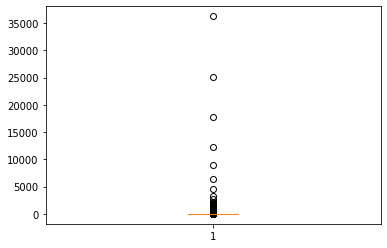

In [0]:
plt.boxplot(MSM_table_2h.IPTW) #75896

In [0]:
MSM_table_2h.IPTW.mean()

6.032331114217466

In [0]:
X = MSM_table_2h[['tr_t_min_1', 'age', 'female', 	'oasis',	'elixhauser',	'explicit_sepsis',	'vaso']]
y = MSM_table_2h['death_t']

# Instantiate a binomial family model with the logit function.
MSM_model = sm.GLM(y, X, family = sm.families.Binomial(), links = sm.genmod.families.links.logit, freq_weights=MSM_table_2h.IPTW.astype(np.float64))
# MSM_model = sm.GLM(y, X, links = sm.genmod.families.links.logit, freq_weights = MSM_table.IPTW.astype(np.float64))

MSM_result = MSM_model.fit()

print(MSM_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death_t   No. Observations:                71263
Model:                            GLM   Df Residuals:                429875.01
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -56358.
Date:                Thu, 19 Mar 2020   Deviance:                   1.1272e+05
Time:                        16:27:39   Pearson chi2:                 7.74e+08
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
tr_t_min_1          5.9619      0.100     

### 2h and 1%

{'boxes': [<matplotlib.lines.Line2D at 0x7f8bb8514780>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8bb851e390>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8bb84a70f0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8bb851ebe0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8bb8514ac8>,
  <matplotlib.lines.Line2D at 0x7f8bb8514ef0>]}

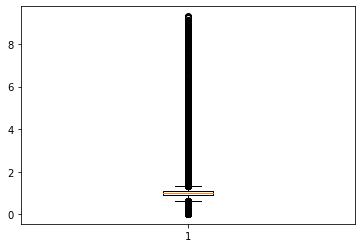

In [0]:
# truncate top 1% and bottom 99% of weights 
MSM_table_trunc_2h = MSM_table_2h[(MSM_table_2h.IPTW < MSM_table_2h.IPTW.quantile(.99)) & (MSM_table_2h.IPTW > MSM_table_2h.IPTW.quantile(.01))]
plt.boxplot(MSM_table_trunc_2h.IPTW)

In [0]:
MSM_table_trunc_2h.IPTW.mean()

1.0360351481067716

In [0]:
X = MSM_table_trunc_2h[['tr_t_min_1', 'age', 'female', 	'oasis',	'elixhauser',	'explicit_sepsis',	'vaso']]
y = MSM_table_trunc_2h['death_t']

# Instantiate a binomial family model with the logit function.
MSM_model = sm.GLM(y, X, family = sm.families.Binomial(), links = sm.genmod.families.links.logit, freq_weights=MSM_table_trunc_2h.IPTW.astype(np.float64))
# MSM_model = sm.GLM(y, X, links = sm.genmod.families.links.logit, freq_weights = MSM_table.IPTW.astype(np.float64))

MSM_result = MSM_model.fit()

print(MSM_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death_t   No. Observations:                69837
Model:                            GLM   Df Residuals:                 72346.59
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1737.8
Date:                Thu, 19 Mar 2020   Deviance:                       3475.7
Time:                        16:37:52   Pearson chi2:                 1.94e+05
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
tr_t_min_1         -0.9602      0.515     

### 2h and 2% 

In [0]:
### 2h varying truncation

{'boxes': [<matplotlib.lines.Line2D at 0x7f8bb7f7b7f0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8bb7f06a58>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8bb7f0fcc0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8bb7ee5c50>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8bb7f4f6d8>,
  <matplotlib.lines.Line2D at 0x7f8bb7ea4ac8>]}

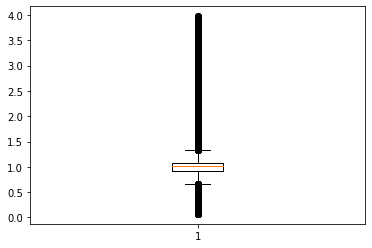

In [0]:
# truncate top 12% and bottom 2 of weights 
MSM_table_trunc_2h_2 = MSM_table_2h[(MSM_table_2h.IPTW < MSM_table_2h.IPTW.quantile(.98)) & (MSM_table_2h.IPTW > MSM_table_2h.IPTW.quantile(.02))]
plt.boxplot(MSM_table_trunc_2h_2.IPTW)

In [0]:
MSM_table_trunc_2h_2.IPTW.mean()

0.9986359721812005

In [0]:
X = MSM_table_trunc_2h_2[['tr_t_min_1', 'age', 'female', 	'oasis',	'elixhauser',	'explicit_sepsis',	'vaso']]
y = MSM_table_trunc_2h_2['death_t']

# Instantiate a binomial family model with the logit function.
MSM_model = sm.GLM(y, X, family = sm.families.Binomial(), links = sm.genmod.families.links.logit, freq_weights=MSM_table_trunc_2h_2.IPTW.astype(np.float64))
# MSM_model = sm.GLM(y, X, links = sm.genmod.families.links.logit, freq_weights = MSM_table.IPTW.astype(np.float64))

MSM_result = MSM_model.fit()

print(MSM_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death_t   No. Observations:                68411
Model:                            GLM   Df Residuals:                 68310.69
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1726.3
Date:                Thu, 19 Mar 2020   Deviance:                       3452.7
Time:                        16:38:50   Pearson chi2:                 1.83e+05
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
tr_t_min_1         -0.8329      0.515     

### 3h and 0%

In [0]:
def reformat_3h(this_index, SF_raw, Treamtment_raw):
  # initialize empty dataFrame
    # index
  dates_index = pd.date_range(start=cohort.mv_starttime.loc[this_index],
                end = cohort.mv_endtime.loc[this_index],
                freq = '3H' )
    # DataFrame
  date = pd.DataFrame(index = pd.Index(dates_index, name = 'MV_date'))
    # Columns
  # date['ID'] = np.full(len(dates_index), this_index)
  date['subject_id'] = np.full(len(dates_index), this_index[0])
  date['hadm_id'] = np.full(len(dates_index), this_index[1])
  date['icustay_id'] = np.full(len(dates_index), this_index[2])
  date['SF_ratio'] = np.nan
  date['tr_t_min_1'] = np.zeros(len(dates_index))
  date['tr_t'] = np.zeros(len(dates_index))
  date['death_t'] = np.zeros(len(dates_index))

  # fill the SF ratios
  for index ,row  in SF_raw.loc[SF_raw.icustay_id== this_index[2]].iterrows():
    SF_date = row.sf_charttime
    SF_date_min_1 = (SF_date - pd.DateOffset(hours=1))
    SF_date_min_2 = (SF_date - pd.DateOffset(hours=2))
    if SF_date in dates_index:
      if pd.isnull(date.loc[SF_date, 'SF_ratio']): # check that it is null
          date.loc[SF_date, 'SF_ratio'] = row.SF_ratio
    if SF_date_min_1 in dates_index:
      if pd.isnull(date.loc[SF_date_min_1, 'SF_ratio']): # check that it is null
          date.loc[SF_date_min_1, 'SF_ratio'] = row.SF_ratio
    if SF_date_min_2 in dates_index:
      if pd.isnull(date.loc[SF_date_min_2, 'SF_ratio']): # check that it is null
          date.loc[SF_date_min_2, 'SF_ratio'] = row.SF_ratio
      # elif date.loc[SF_date, 'SF_ratio'] > row.SF_ratio:
      #     date.loc[SF_date, 'SF_ratio'] = row.SF_ratio
      
  # fill the treatment history 
  for index ,row  in Treamtment_raw.loc[Treamtment_raw.icustay_id== this_index[2]].iterrows():
    tr_date = row.NMBA_timestamp.floor('h')
    tr_date_min_1 = (tr_date - pd.DateOffset(hours=1))
    tr_date_min_2 = (tr_date - pd.DateOffset(hours=2))
    if tr_date in dates_index: 
      date.loc[tr_date, 'tr_t'] = 1
    if tr_date_min_1 in dates_index: 
      date.loc[tr_date_min_1, 'tr_t'] = 1
    if tr_date_min_2 in dates_index: 
      date.loc[tr_date_min_2, 'tr_t'] = 1
      # next_hour = (tr_date + pd.DateOffset(hours=1))
      # if next_hour in dates_index:
      #   date.loc[next_hour, 'tr_t_min_1'] = 1

  # Fill in death date 
  dod = cohort.loc[this_index].dod.floor('h')
  dod_min_1 = dod - pd.DateOffset(hours=1)
  dod_min_2 = dod - pd.DateOffset(hours=2)
  if pd.notnull(dod): 
    # print(cohort.loc[this_index].dod)
    if dod in dates_index:
      date.loc[dod, 'death_t'] = 1
  if pd.notnull(dod_min_1):
    if dod_min_1 in dates_index:
      date.loc[dod_min_1, 'death_t'] = 1  
  if pd.notnull(dod_min_2):
    if dod_min_2 in dates_index:
      date.loc[dod_min_2, 'death_t'] = 1    
  return date

In [0]:
PMF_table_3h = pd.DataFrame(columns = ['subject_id', 'hadm_id', 'icustay_id', 'SF_ratio', 'tr_t_min_1', 'tr_t', 'death_t'])
PMF_table_3h.index.name = 'MV_date'

for index in cohort.index: 
  PMF_concat = reformat_3h(index, SF_raw, Treamtment_raw)
  PMF_table_3h = pd.concat([PMF_table_3h, PMF_concat])

In [0]:
PMF_table_3h.tr_t_min_1[1:] = PMF_table_3h.tr_t[:-1]
PMF_table_3h.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(140648, 7)

In [0]:
MSM_table_3h = PMF_table_3h[PMF_table_3h.SF_ratio.notnull()] 
MSM_table_3h = MSM_table_3h.merge(cohort, how = 'left' , on = ['subject_id', 'hadm_id', 'icustay_id'])
MSM_table_3h

,subject_id,hadm_id,icustay_id,SF_ratio,tr_t_min_1,tr_t,death_t,mv_durations_hours,mv_starttime,mv_endtime,min_pao2fio2,max_peep,age,dod,los,weight,height,BMI,admission_type,admission_location,LANGUAGE,religion,marital_status,ethnicity,diagnosis,female,oasis,elixhauser,explicit_sepsis,vaso,mortality
0,10852,139654,253340,1.371429,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0
1,10852,139654,253340,1.920000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0
2,10852,139654,253340,2.450000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0
3,10852,139654,253340,2.400000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0
4,10852,139654,253340,1.940000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66317,6025,184173,233970,1.616667,0.0,0.0,0.0,5.86667,2109-12-13 12:00:00,2109-12-13 17:52:00,138.33333,5.0,83.0,NaT,12.4215,53.0,152.40,22.8,EMERGENCY,EMERGENCY ROOM ADMIT,None,CATHOLIC,None,WHITE,PERFORATED VISCUS,1,52,12,0,1,0
66318,14858,191758,211210,2.000000,0.0,0.0,0.0,6.00000,2133-04-10 14:00:00,2133-04-10 20:00:00,123.00000,5.0,70.0,NaT,1.8278,81.6,157.48,32.9,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,None,CATHOLIC,SINGLE,WHITE,UNSTABLE ANGINA,1,51,0,0,1,0
66319,14858,191758,211210,1.900000,0.0,0.0,0.0,6.00000,2133-04-10 14:00:00,2133-04-10 20:00:00,123.00000,5.0,70.0,NaT,1.8278,81.6,157.48,32.9,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,None,CATHOLIC,SINGLE,WHITE,UNSTABLE ANGINA,1,51,0,0,1,0
66320,84717,134774,234116,2.250000,0.0,0.0,0.0,2.00000,2104-09-21 05:00:00,2104-09-21 07:00:00,76.00000,5.0,77.0,2104-09-22,2.1108,41.3,NaN,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,MARRIED,WHITE,SEPSIS,1,52,10,1,1,1


In [0]:
#PMF_table_full = PMF_table_full.groupby(['subject_id',	'hadm_id',	'icustay_id']).tail(24) # remember to delete this if it doesn't work!!!!!

In [0]:
y, X = dmatrices('tr_t ~  SF_ratio + tr_t_min_1', data=MSM_table_3h, return_type='dataframe')
# y, X = dmatrices('tr_t ~  pao2fio2', data=PF_table_full, return_type='dataframe')
logit_model_den = sm.Logit(y,X)
fitted_model_den=logit_model_den.fit()
print(fitted_model_den.summary())

Optimization terminated successfully.
         Current function value: 0.070767
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   tr_t   No. Observations:                66322
Model:                          Logit   Df Residuals:                    66319
Method:                           MLE   Df Model:                            2
Date:                Thu, 19 Mar 2020   Pseudo R-squ.:                  0.5934
Time:                        14:00:10   Log-Likelihood:                -4693.4
converged:                       True   LL-Null:                       -11542.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4733      0.144    -10.224      0.000      -1.756      -1.191
SF_ratio      -1.6607      0.

In [0]:
y, X = dmatrices('tr_t ~ tr_t_min_1 + age + female + oasis + elixhauser + explicit_sepsis + vaso', data = MSM_table_3h, return_type='dataframe')
logit_model_nom = sm.Logit(y,X)
fitted_model_nom = logit_model_nom.fit()
print(fitted_model_nom.summary())

Optimization terminated successfully.
         Current function value: 0.073008
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   tr_t   No. Observations:                66322
Model:                          Logit   Df Residuals:                    66314
Method:                           MLE   Df Model:                            7
Date:                Thu, 19 Mar 2020   Pseudo R-squ.:                  0.5805
Time:                        14:00:12   Log-Likelihood:                -4842.1
converged:                       True   LL-Null:                       -11542.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -4.0240      0.189    -21.341      0.000      -4.394      -3.654
tr_t_min_1    

In [0]:
MSM_table_3h["den"] = np.nan
MSM_table_3h["nom"] = np.nan

In [0]:
cols = MSM_table_3h.columns
BC = ['tr_t_min_1', 'age', 'female', 'oasis', 'elixhauser', 'explicit_sepsis', 'vaso']
TDC = ['SF_ratio', 'tr_t_min_1']
patient_id = ['subject_id', 'hadmi_id', 'icustay_id']
BC_index = [MSM_table_3h.columns.get_loc(c) for c in cols if c in BC]
TDC_index = [MSM_table_3h.columns.get_loc(c) for c in cols if c in TDC]
patient_id_index = [MSM_table_3h.columns.get_loc(c) for c in cols if c in patient_id]

In [0]:
den_index = MSM_table_3h.columns.get_loc("den")
nom_index = MSM_table_3h.columns.get_loc("nom")
trt_index = MSM_table_3h.columns.get_loc("tr_t")

In [0]:
for i in range(len(MSM_table_3h)):
  if i == 0: 
    BC_prob = fitted_model_nom.predict([1] + list(MSM_table_3h.iloc[i, BC_index]))[0] #This is for the first row
    TDC_prob = fitted_model_den.predict([1] + list(MSM_table_3h.iloc[i, TDC_index]))[0] #This is for the first row
    if MSM_table_3h.iloc[i, trt_index] == 1: # if treated
      MSM_table_3h.iloc[i, nom_index] = BC_prob # get probability treatment
      MSM_table_3h.iloc[i, den_index] = TDC_prob # get probability treatment
    else:  # if not treated
      MSM_table_3h.iloc[i, nom_index] = 1 - BC_prob # get probability treatment
      MSM_table_3h.iloc[i, den_index] = 1 - TDC_prob # get probability treatment  
  else: # if not first row
    if (MSM_table_3h.iloc[i, patient_id_index] == MSM_table_3h.iloc[i - 1, patient_id_index]).all(): # if same patient as previous row 
      sing_BC_prob = fitted_model_nom.predict([1] + list(MSM_table_3h.iloc[i, BC_index]))[0] 
      sing_TDC_prob = fitted_model_den.predict([1] + list(MSM_table_3h.iloc[i, TDC_index]))[0] 
      if MSM_table_3h.iloc[i, trt_index] == 1: # if treated
        MSM_table_3h.iloc[i, nom_index] = sing_BC_prob * MSM_table_3h.iloc[i-1, nom_index] # get probability treatment multiplied by previous day treatment probability
        MSM_table_3h.iloc[i, den_index] = sing_TDC_prob * MSM_table_3h.iloc[i-1, den_index] # get probability treatment multiplied by previous day treatment probability
      else:  # if not treated
        MSM_table_3h.iloc[i, nom_index] = (1 - sing_BC_prob) * MSM_table_3h.iloc[i-1, nom_index] # get probability non-treatment multiplied by previous day treatment probability
        MSM_table_3h.iloc[i, den_index] = (1 - sing_TDC_prob) * MSM_table_3h.iloc[i-1, den_index] # get probability non-treatment multiplied by previous day treatment probability
    else: # if not same patient
      BC_prob = fitted_model_nom.predict([1] + list(MSM_table_3h.iloc[i, BC_index]))[0] #This is for the first row
      TDC_prob = fitted_model_den.predict([1] + list(MSM_table_3h.iloc[i, TDC_index]))[0] #This is for the first row
      if MSM_table_3h.iloc[i, trt_index] == 1: # if treated
        MSM_table_3h.iloc[i, nom_index] = BC_prob # get probability treatment
        MSM_table_3h.iloc[i, den_index] = TDC_prob # get probability treatment
      else:  # if not treated
        MSM_table_3h.iloc[i, nom_index] = 1 - BC_prob # get probability treatment
        MSM_table_3h.iloc[i, den_index] = 1 - TDC_prob # get probability treatment  

In [0]:
MSM_table_3h['IPTW'] = MSM_table_3h.nom / MSM_table_3h.den

In [0]:
MSM_table_3h

,subject_id,hadm_id,icustay_id,SF_ratio,tr_t_min_1,tr_t,death_t,mv_durations_hours,mv_starttime,mv_endtime,min_pao2fio2,max_peep,age,dod,los,weight,height,BMI,admission_type,admission_location,LANGUAGE,religion,marital_status,ethnicity,diagnosis,female,oasis,elixhauser,explicit_sepsis,vaso,mortality,den,nom,IPTW
0,10852,139654,253340,1.371429,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.977043,0.995720,1.019116
1,10852,139654,253340,1.920000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.967898,0.991459,1.024342
2,10852,139654,253340,2.450000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.964121,0.987216,1.023955
3,10852,139654,253340,2.400000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.960033,0.982991,1.023914
4,10852,139654,253340,1.940000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.951339,0.978785,1.028850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66317,6025,184173,233970,1.616667,0.0,0.0,0.0,5.86667,2109-12-13 12:00:00,2109-12-13 17:52:00,138.33333,5.0,83.0,NaT,12.4215,53.0,152.40,22.8,EMERGENCY,EMERGENCY ROOM ADMIT,None,CATHOLIC,None,WHITE,PERFORATED VISCUS,1,52,12,0,1,0,0.984605,0.994223,1.009769
66318,14858,191758,211210,2.000000,0.0,0.0,0.0,6.00000,2133-04-10 14:00:00,2133-04-10 20:00:00,123.00000,5.0,70.0,NaT,1.8278,81.6,157.48,32.9,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,None,CATHOLIC,SINGLE,WHITE,UNSTABLE ANGINA,1,51,0,0,1,0,0.991795,0.991575,0.999778
66319,14858,191758,211210,1.900000,0.0,0.0,0.0,6.00000,2133-04-10 14:00:00,2133-04-10 20:00:00,123.00000,5.0,70.0,NaT,1.8278,81.6,157.48,32.9,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,None,CATHOLIC,SINGLE,WHITE,UNSTABLE ANGINA,1,51,0,0,1,0,0.982202,0.983221,1.001037
66320,84717,134774,234116,2.250000,0.0,0.0,0.0,2.00000,2104-09-21 05:00:00,2104-09-21 07:00:00,76.00000,5.0,77.0,2104-09-22,2.1108,41.3,NaN,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,MARRIED,WHITE,SEPSIS,1,52,10,1,1,1,0.994568,0.992942,0.998365


{'boxes': [<matplotlib.lines.Line2D at 0x7f8baf1ceb70>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8baf1d75c0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8baf1e0080>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8baf1d7cc0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8baf1cee80>,
  <matplotlib.lines.Line2D at 0x7f8baf1d7240>]}

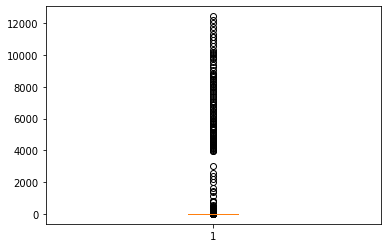

In [0]:
plt.boxplot(MSM_table_3h.IPTW)

In [0]:
MSM_table_3h.IPTW.mean()

12.38890765378475

In [0]:
X = MSM_table_3h[['tr_t_min_1', 'age', 'female', 	'oasis',	'elixhauser',	'explicit_sepsis',	'vaso']]
y = MSM_table_3h['death_t']

# Instantiate a binomial family model with the logit function.
MSM_model = sm.GLM(y, X, family = sm.families.Binomial(), links = sm.genmod.families.links.logit, freq_weights=MSM_table_3h.IPTW.astype(np.float64))
# MSM_model = sm.GLM(y, X, links = sm.genmod.families.links.logit, freq_weights = MSM_table.IPTW.astype(np.float64))

MSM_result = MSM_model.fit()

print(MSM_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death_t   No. Observations:                66322
Model:                            GLM   Df Residuals:                821650.13
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21128.
Date:                Thu, 19 Mar 2020   Deviance:                       42256.
Time:                        16:48:12   Pearson chi2:                 6.00e+07
No. Iterations:                    12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
tr_t_min_1          5.0963      0.083     

### 3h and 1%

{'boxes': [<matplotlib.lines.Line2D at 0x7f8bb8420780>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8bb8429550>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8bb8433240>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8bb8429d30>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8bb8420b38>,
  <matplotlib.lines.Line2D at 0x7f8bb8429080>]}

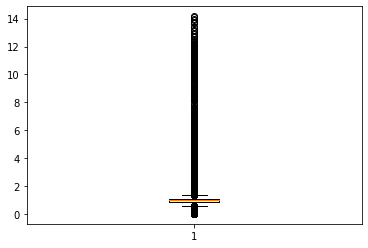

In [0]:
# truncate top 1% and bottom 99% of weights 
MSM_table_trunc_3h = MSM_table_3h[(MSM_table_3h.IPTW < MSM_table_3h.IPTW.quantile(.99)) & (MSM_table_3h.IPTW > MSM_table_3h.IPTW.quantile(.01))]
plt.boxplot(MSM_table_trunc_3h.IPTW)

In [0]:
MSM_table_trunc_3h.IPTW.mean()

1.0413777792288832

In [0]:
X = MSM_table_trunc_3h[['tr_t_min_1', 'age', 'female', 	'oasis',	'elixhauser',	'explicit_sepsis',	'vaso']]
y = MSM_table_trunc_3h['death_t']

# Instantiate a binomial family model with the logit function.
MSM_model = sm.GLM(y, X, family = sm.families.Binomial(), links = sm.genmod.families.links.logit, freq_weights=MSM_table_trunc_3h.IPTW.astype(np.float64))
# MSM_model = sm.GLM(y, X, links = sm.genmod.families.links.logit, freq_weights = MSM_table.IPTW.astype(np.float64))

MSM_result = MSM_model.fit()

print(MSM_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death_t   No. Observations:                64994
Model:                            GLM   Df Residuals:                 67676.31
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1951.8
Date:                Thu, 19 Mar 2020   Deviance:                       3903.7
Time:                        14:06:29   Pearson chi2:                 1.76e+05
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
tr_t_min_1         -1.5282      0.513     

### 3h and 2%

{'boxes': [<matplotlib.lines.Line2D at 0x7f8baf141f60>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8baf14b9b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8baf154470>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8baf1540f0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8baf14b2b0>,
  <matplotlib.lines.Line2D at 0x7f8baf14b630>]}

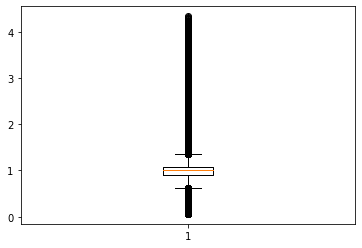

In [0]:
# truncate top 2% and bottom 2% of weights 
MSM_table_trunc_3h_2 = MSM_table_3h[(MSM_table_3h.IPTW < MSM_table_3h.IPTW.quantile(.98)) & (MSM_table_3h.IPTW > MSM_table_3h.IPTW.quantile(.02))]
plt.boxplot(MSM_table_trunc_3h_2.IPTW)

In [0]:
MSM_table_trunc_3h_2.IPTW.mean()

0.9880386931080977

In [0]:
X = MSM_table_trunc_3h_2[['tr_t_min_1', 'age', 'female', 	'oasis',	'elixhauser',	'explicit_sepsis',	'vaso']]
y = MSM_table_trunc_3h_2['death_t']

# Instantiate a binomial family model with the logit function.
MSM_model = sm.GLM(y, X, family = sm.families.Binomial(), links = sm.genmod.families.links.logit, freq_weights=MSM_table_trunc_3h_2.IPTW.astype(np.float64))
# MSM_model = sm.GLM(y, X, links = sm.genmod.families.links.logit, freq_weights = MSM_table.IPTW.astype(np.float64))

MSM_result = MSM_model.fit()

print(MSM_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death_t   No. Observations:                63668
Model:                            GLM   Df Residuals:                 62899.45
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1849.4
Date:                Thu, 19 Mar 2020   Deviance:                       3698.8
Time:                        16:51:43   Pearson chi2:                 1.66e+05
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
tr_t_min_1         -1.0802      0.513     

### 4H and 0%


In [0]:
def reformat_4h(this_index, SF_raw, Treamtment_raw):
  # initialize empty dataFrame
    # index
  dates_index = pd.date_range(start=cohort.mv_starttime.loc[this_index],
                end = cohort.mv_endtime.loc[this_index],
                freq = '4H' )
    # DataFrame
  date = pd.DataFrame(index = pd.Index(dates_index, name = 'MV_date'))
    # Columns
  # date['ID'] = np.full(len(dates_index), this_index)
  date['subject_id'] = np.full(len(dates_index), this_index[0])
  date['hadm_id'] = np.full(len(dates_index), this_index[1])
  date['icustay_id'] = np.full(len(dates_index), this_index[2])
  date['SF_ratio'] = np.nan
  date['tr_t_min_1'] = np.zeros(len(dates_index))
  date['tr_t'] = np.zeros(len(dates_index))
  date['death_t'] = np.zeros(len(dates_index))

  # fill the SF ratios
  for index ,row  in SF_raw.loc[SF_raw.icustay_id== this_index[2]].iterrows():
    SF_date = row.sf_charttime
    SF_date_min_1 = (SF_date - pd.DateOffset(hours=1))
    SF_date_min_2 = (SF_date - pd.DateOffset(hours=2))
    SF_date_min_3 = (SF_date - pd.DateOffset(hours=3))
    if SF_date in dates_index:
      if pd.isnull(date.loc[SF_date, 'SF_ratio']): # check that it is null
          date.loc[SF_date, 'SF_ratio'] = row.SF_ratio
    if SF_date_min_1 in dates_index:
      if pd.isnull(date.loc[SF_date_min_1, 'SF_ratio']): # check that it is null
          date.loc[SF_date_min_1, 'SF_ratio'] = row.SF_ratio
    if SF_date_min_2 in dates_index:
      if pd.isnull(date.loc[SF_date_min_2, 'SF_ratio']): # check that it is null
          date.loc[SF_date_min_2, 'SF_ratio'] = row.SF_ratio
    if SF_date_min_3 in dates_index:
      if pd.isnull(date.loc[SF_date_min_3, 'SF_ratio']): # check that it is null
          date.loc[SF_date_min_3, 'SF_ratio'] = row.SF_ratio
      # elif date.loc[SF_date, 'SF_ratio'] > row.SF_ratio:
      #     date.loc[SF_date, 'SF_ratio'] = row.SF_ratio
      
  # fill the treatment history 
  for index ,row  in Treamtment_raw.loc[Treamtment_raw.icustay_id== this_index[2]].iterrows():
    tr_date = row.NMBA_timestamp.floor('h')
    tr_date_min_1 = (tr_date - pd.DateOffset(hours=1))
    tr_date_min_2 = (tr_date - pd.DateOffset(hours=2))
    tr_date_min_3 = (tr_date - pd.DateOffset(hours=3))
    if tr_date in dates_index: 
      date.loc[tr_date, 'tr_t'] = 1
    if tr_date_min_1 in dates_index: 
      date.loc[tr_date_min_1, 'tr_t'] = 1
    if tr_date_min_2 in dates_index: 
      date.loc[tr_date_min_2, 'tr_t'] = 1
    if tr_date_min_3 in dates_index: 
      date.loc[tr_date_min_3, 'tr_t'] = 1
      # next_hour = (tr_date + pd.DateOffset(hours=1))
      # if next_hour in dates_index:
      #   date.loc[next_hour, 'tr_t_min_1'] = 1

  # Fill in death date 
  dod = cohort.loc[this_index].dod.floor('h')
  dod_min_1 = dod - pd.DateOffset(hours=1)
  dod_min_2 = dod - pd.DateOffset(hours=2)
  dod_min_3 = dod - pd.DateOffset(hours=3)
  if pd.notnull(dod): 
    # print(cohort.loc[this_index].dod)
    if dod in dates_index:
      date.loc[dod, 'death_t'] = 1
  if pd.notnull(dod_min_1):
    if dod_min_1 in dates_index:
      date.loc[dod_min_1, 'death_t'] = 1  
  if pd.notnull(dod_min_2):
    if dod_min_2 in dates_index:
      date.loc[dod_min_2, 'death_t'] = 1  
  if pd.notnull(dod_min_3):
    if dod_min_3 in dates_index:
      date.loc[dod_min_3, 'death_t'] = 1    
  return date

In [0]:
PMF_table_4h = pd.DataFrame(columns = ['subject_id', 'hadm_id', 'icustay_id', 'SF_ratio', 'tr_t_min_1', 'tr_t', 'death_t'])
PMF_table_4h.index.name = 'MV_date'

for index in cohort.index: 
  PMF_concat = reformat_4h(index, SF_raw, Treamtment_raw)
  PMF_table_4h = pd.concat([PMF_table_4h, PMF_concat])

In [0]:
PMF_table_4h.tr_t_min_1[1:] = PMF_table_4h.tr_t[:-1]
PMF_table_4h.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(105952, 7)

In [0]:
MSM_table_4h = PMF_table_4h[PMF_table_4h.SF_ratio.notnull()] 
MSM_table_4h = MSM_table_4h.merge(cohort, how = 'left' , on = ['subject_id', 'hadm_id', 'icustay_id'])
MSM_table_4h

,subject_id,hadm_id,icustay_id,SF_ratio,tr_t_min_1,tr_t,death_t,mv_durations_hours,mv_starttime,mv_endtime,min_pao2fio2,max_peep,age,dod,los,weight,height,BMI,admission_type,admission_location,LANGUAGE,religion,marital_status,ethnicity,diagnosis,female,oasis,elixhauser,explicit_sepsis,vaso,mortality
0,10852,139654,253340,1.371429,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0
1,10852,139654,253340,1.920000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0
2,10852,139654,253340,2.450000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0
3,10852,139654,253340,2.400000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0
4,27172,183106,209167,1.250000,0.0,0.0,0.0,155.00000,2111-09-06 01:00:00,2111-09-12 12:00:00,76.25000,12.0,55.0,NaT,16.8144,NaN,177.80,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,MARRIED,WHITE,PNEUMONIA,0,54,17,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60243,42860,160594,219786,1.940000,0.0,0.0,0.0,5.48333,2113-01-23 19:00:00,2113-01-24 00:29:00,79.00000,5.0,62.0,NaT,1.2864,88.4,180.00,27.3,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,PROTESTANT QUAKER,SINGLE,BLACK/AFRICAN AMERICAN,MITRAL VALVE STENOSIS; SHORTNESS OF BREATH\LEF...,0,33,0,0,1,0
60244,6025,184173,233970,1.616667,0.0,0.0,0.0,5.86667,2109-12-13 12:00:00,2109-12-13 17:52:00,138.33333,5.0,83.0,NaT,12.4215,53.0,152.40,22.8,EMERGENCY,EMERGENCY ROOM ADMIT,None,CATHOLIC,None,WHITE,PERFORATED VISCUS,1,52,12,0,1,0
60245,14858,191758,211210,1.900000,0.0,0.0,0.0,6.00000,2133-04-10 14:00:00,2133-04-10 20:00:00,123.00000,5.0,70.0,NaT,1.8278,81.6,157.48,32.9,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,None,CATHOLIC,SINGLE,WHITE,UNSTABLE ANGINA,1,51,0,0,1,0
60246,84717,134774,234116,2.250000,0.0,0.0,0.0,2.00000,2104-09-21 05:00:00,2104-09-21 07:00:00,76.00000,5.0,77.0,2104-09-22,2.1108,41.3,NaN,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,MARRIED,WHITE,SEPSIS,1,52,10,1,1,1


In [0]:
#PMF_table_full = PMF_table_full.groupby(['subject_id',	'hadm_id',	'icustay_id']).tail(24) # remember to delete this if it doesn't work!!!!!

In [0]:
y, X = dmatrices('tr_t ~  SF_ratio + tr_t_min_1', data=MSM_table_4h, return_type='dataframe')
# y, X = dmatrices('tr_t ~  pao2fio2', data=PF_table_full, return_type='dataframe')
logit_model_den = sm.Logit(y,X)
fitted_model_den=logit_model_den.fit()
print(fitted_model_den.summary())

Optimization terminated successfully.
         Current function value: 0.071544
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   tr_t   No. Observations:                60248
Model:                          Logit   Df Residuals:                    60245
Method:                           MLE   Df Model:                            2
Date:                Thu, 19 Mar 2020   Pseudo R-squ.:                  0.6061
Time:                        14:15:10   Log-Likelihood:                -4310.4
converged:                       True   LL-Null:                       -10943.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5533      0.150    -10.330      0.000      -1.848      -1.259
SF_ratio      -1.6173      0.

In [0]:
y, X = dmatrices('tr_t ~ tr_t_min_1 + age + female + oasis + elixhauser + explicit_sepsis + vaso', data = MSM_table_4h, return_type='dataframe')
logit_model_nom = sm.Logit(y,X)
fitted_model_nom = logit_model_nom.fit()
print(fitted_model_nom.summary())

Optimization terminated successfully.
         Current function value: 0.073811
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   tr_t   No. Observations:                60248
Model:                          Logit   Df Residuals:                    60240
Method:                           MLE   Df Model:                            7
Date:                Thu, 19 Mar 2020   Pseudo R-squ.:                  0.5936
Time:                        14:15:14   Log-Likelihood:                -4447.0
converged:                       True   LL-Null:                       -10943.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -4.2501      0.198    -21.494      0.000      -4.638      -3.863
tr_t_min_1    

In [0]:
MSM_table_4h["den"] = np.nan
MSM_table_4h["nom"] = np.nan

In [0]:
cols = MSM_table_4h.columns
BC = ['tr_t_min_1', 'age', 'female', 'oasis', 'elixhauser', 'explicit_sepsis', 'vaso']
TDC = ['SF_ratio', 'tr_t_min_1']
patient_id = ['subject_id', 'hadmi_id', 'icustay_id']
BC_index = [MSM_table_4h.columns.get_loc(c) for c in cols if c in BC]
TDC_index = [MSM_table_4h.columns.get_loc(c) for c in cols if c in TDC]
patient_id_index = [MSM_table_4h.columns.get_loc(c) for c in cols if c in patient_id]

In [0]:
den_index = MSM_table_4h.columns.get_loc("den")
nom_index = MSM_table_4h.columns.get_loc("nom")
trt_index = MSM_table_4h.columns.get_loc("tr_t")

In [0]:
for i in range(len(MSM_table_4h)):
  if i == 0: 
    BC_prob = fitted_model_nom.predict([1] + list(MSM_table_4h.iloc[i, BC_index]))[0] #This is for the first row
    TDC_prob = fitted_model_den.predict([1] + list(MSM_table_4h.iloc[i, TDC_index]))[0] #This is for the first row
    if MSM_table_4h.iloc[i, trt_index] == 1: # if treated
      MSM_table_4h.iloc[i, nom_index] = BC_prob # get probability treatment
      MSM_table_4h.iloc[i, den_index] = TDC_prob # get probability treatment
    else:  # if not treated
      MSM_table_4h.iloc[i, nom_index] = 1 - BC_prob # get probability treatment
      MSM_table_4h.iloc[i, den_index] = 1 - TDC_prob # get probability treatment  
  else: # if not first row
    if (MSM_table_4h.iloc[i, patient_id_index] == MSM_table_4h.iloc[i - 1, patient_id_index]).all(): # if same patient as previous row 
      sing_BC_prob = fitted_model_nom.predict([1] + list(MSM_table_4h.iloc[i, BC_index]))[0] 
      sing_TDC_prob = fitted_model_den.predict([1] + list(MSM_table_4h.iloc[i, TDC_index]))[0] 
      if MSM_table_4h.iloc[i, trt_index] == 1: # if treated
        MSM_table_4h.iloc[i, nom_index] = sing_BC_prob * MSM_table_4h.iloc[i-1, nom_index] # get probability treatment multiplied by previous day treatment probability
        MSM_table_4h.iloc[i, den_index] = sing_TDC_prob * MSM_table_4h.iloc[i-1, den_index] # get probability treatment multiplied by previous day treatment probability
      else:  # if not treated
        MSM_table_4h.iloc[i, nom_index] = (1 - sing_BC_prob) * MSM_table_4h.iloc[i-1, nom_index] # get probability non-treatment multiplied by previous day treatment probability
        MSM_table_4h.iloc[i, den_index] = (1 - sing_TDC_prob) * MSM_table_4h.iloc[i-1, den_index] # get probability non-treatment multiplied by previous day treatment probability
    else: # if not same patient
      BC_prob = fitted_model_nom.predict([1] + list(MSM_table_4h.iloc[i, BC_index]))[0] #This is for the first row
      TDC_prob = fitted_model_den.predict([1] + list(MSM_table_4h.iloc[i, TDC_index]))[0] #This is for the first row
      if MSM_table_4h.iloc[i, trt_index] == 1: # if treated
        MSM_table_4h.iloc[i, nom_index] = BC_prob # get probability treatment
        MSM_table_4h.iloc[i, den_index] = TDC_prob # get probability treatment
      else:  # if not treated
        MSM_table_4h.iloc[i, nom_index] = 1 - BC_prob # get probability treatment
        MSM_table_4h.iloc[i, den_index] = 1 - TDC_prob # get probability treatment  

In [0]:
MSM_table_4h['IPTW'] = MSM_table_4h.nom / MSM_table_4h.den

In [0]:
MSM_table_4h

,subject_id,hadm_id,icustay_id,SF_ratio,tr_t_min_1,tr_t,death_t,mv_durations_hours,mv_starttime,mv_endtime,min_pao2fio2,max_peep,age,dod,los,weight,height,BMI,admission_type,admission_location,LANGUAGE,religion,marital_status,ethnicity,diagnosis,female,oasis,elixhauser,explicit_sepsis,vaso,mortality,den,nom,IPTW
0,10852,139654,253340,1.371429,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.977496,0.995860,1.018787
1,10852,139654,253340,1.920000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.968315,0.991737,1.024187
2,10852,139654,253340,2.450000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.964435,0.987630,1.024051
3,10852,139654,253340,2.400000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.960247,0.983541,1.024259
4,27172,183106,209167,1.250000,0.0,0.0,0.0,155.00000,2111-09-06 01:00:00,2111-09-12 12:00:00,76.25000,12.0,55.0,NaT,16.8144,NaN,177.80,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,MARRIED,WHITE,PNEUMONIA,0,54,17,1,1,0,0.972746,0.987709,1.015383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60243,42860,160594,219786,1.940000,0.0,0.0,0.0,5.48333,2113-01-23 19:00:00,2113-01-24 00:29:00,79.00000,5.0,62.0,NaT,1.2864,88.4,180.00,27.3,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,PROTESTANT QUAKER,SINGLE,BLACK/AFRICAN AMERICAN,MITRAL VALVE STENOSIS; SHORTNESS OF BREATH\LEF...,0,33,0,0,1,0,0.981295,0.978218,0.996864
60244,6025,184173,233970,1.616667,0.0,0.0,0.0,5.86667,2109-12-13 12:00:00,2109-12-13 17:52:00,138.33333,5.0,83.0,NaT,12.4215,53.0,152.40,22.8,EMERGENCY,EMERGENCY ROOM ADMIT,None,CATHOLIC,None,WHITE,PERFORATED VISCUS,1,52,12,0,1,0,0.984752,0.993619,1.009004
60245,14858,191758,211210,1.900000,0.0,0.0,0.0,6.00000,2133-04-10 14:00:00,2133-04-10 20:00:00,123.00000,5.0,70.0,NaT,1.8278,81.6,157.48,32.9,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,None,CATHOLIC,SINGLE,WHITE,UNSTABLE ANGINA,1,51,0,0,1,0,0.990303,0.991036,1.000741
60246,84717,134774,234116,2.250000,0.0,0.0,0.0,2.00000,2104-09-21 05:00:00,2104-09-21 07:00:00,76.00000,5.0,77.0,2104-09-22,2.1108,41.3,NaN,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,MARRIED,WHITE,SEPSIS,1,52,10,1,1,1,0.994471,0.992762,0.998281


{'boxes': [<matplotlib.lines.Line2D at 0x7f8baef699e8>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8baeef3438>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8baeef3eb8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8baeef3b38>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8baef69cf8>,
  <matplotlib.lines.Line2D at 0x7f8baeef30b8>]}

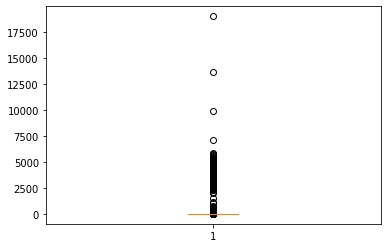

In [0]:
plt.boxplot(MSM_table_4h.IPTW) #75896

In [0]:
MSM_table_4h.IPTW.mean()

7.198417719697282

In [0]:
X = MSM_table_4h[['tr_t_min_1', 'age', 'female', 	'oasis',	'elixhauser',	'explicit_sepsis',	'vaso']]
y = MSM_table_4h['death_t']

# Instantiate a binomial family model with the logit function.
MSM_model = sm.GLM(y, X, family = sm.families.Binomial(), links = sm.genmod.families.links.logit, freq_weights=MSM_table_4h.IPTW.astype(np.float64))
# MSM_model = sm.GLM(y, X, links = sm.genmod.families.links.logit, freq_weights = MSM_table.IPTW.astype(np.float64))

MSM_result = MSM_model.fit()

print(MSM_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death_t   No. Observations:                60248
Model:                            GLM   Df Residuals:                433683.27
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32222.
Date:                Thu, 19 Mar 2020   Deviance:                       64445.
Time:                        16:58:30   Pearson chi2:                 7.25e+06
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
tr_t_min_1          4.7888      0.080     

### 4h ans 1%

{'boxes': [<matplotlib.lines.Line2D at 0x7f8bb7f4f518>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8bb7f5a208>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8bb7f5ae10>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8bb7f5aa20>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8bb7f4f908>,
  <matplotlib.lines.Line2D at 0x7f8bb7f4fcf8>]}

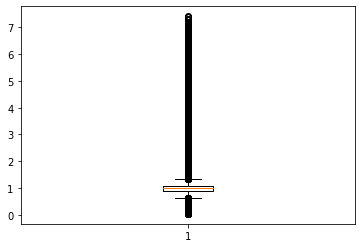

In [0]:
# truncate top 1% and bottom 99% of weights 
MSM_table_trunc_4h = MSM_table_4h[(MSM_table_4h.IPTW < MSM_table_4h.IPTW.quantile(.99)) & (MSM_table_4h.IPTW > MSM_table_4h.IPTW.quantile(.01))]
plt.boxplot(MSM_table_trunc_4h.IPTW)

In [0]:
MSM_table_trunc_4h.IPTW.mean()

1.0154932496607592

In [0]:
X = MSM_table_trunc_4h[['tr_t_min_1', 'age', 'female', 	'oasis',	'elixhauser',	'explicit_sepsis',	'vaso']]
y = MSM_table_trunc_4h['death_t']

# Instantiate a binomial family model with the logit function.
MSM_model = sm.GLM(y, X, family = sm.families.Binomial(), links = sm.genmod.families.links.logit, freq_weights=MSM_table_trunc_4h.IPTW.astype(np.float64))
# MSM_model = sm.GLM(y, X, links = sm.genmod.families.links.logit, freq_weights = MSM_table.IPTW.astype(np.float64))

MSM_result = MSM_model.fit()

print(MSM_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death_t   No. Observations:                59042
Model:                            GLM   Df Residuals:                 59949.75
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1988.4
Date:                Thu, 19 Mar 2020   Deviance:                       3976.7
Time:                        17:00:38   Pearson chi2:                 1.47e+05
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
tr_t_min_1          0.0348      0.255     

### 4h ans 2%

{'boxes': [<matplotlib.lines.Line2D at 0x7f8baf118cf8>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8baf122748>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8baf12c208>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8baf122e48>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8baf122048>,
  <matplotlib.lines.Line2D at 0x7f8baf1223c8>]}

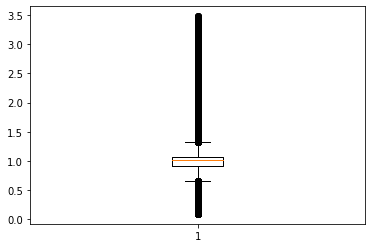

In [0]:
# truncate top 2% and bottom 2% of weights 
MSM_table_trunc_4h_2 = MSM_table_4h[(MSM_table_4h.IPTW < MSM_table_4h.IPTW.quantile(.98)) & (MSM_table_4h.IPTW > MSM_table_4h.IPTW.quantile(.02))]
plt.boxplot(MSM_table_trunc_4h_2.IPTW)

In [0]:
MSM_table_trunc_4h_2.IPTW.mean()

0.9796746659842294

In [0]:
X = MSM_table_trunc_4h_2[['tr_t_min_1', 'age', 'female', 	'oasis',	'elixhauser',	'explicit_sepsis',	'vaso']]
y = MSM_table_trunc_4h_2['death_t']

# Instantiate a binomial family model with the logit function.
MSM_model = sm.GLM(y, X, family = sm.families.Binomial(), links = sm.genmod.families.links.logit, freq_weights=MSM_table_trunc_4h_2.IPTW.astype(np.float64))
# MSM_model = sm.GLM(y, X, links = sm.genmod.families.links.logit, freq_weights = MSM_table.IPTW.astype(np.float64))

MSM_result = MSM_model.fit()

print(MSM_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death_t   No. Observations:                57838
Model:                            GLM   Df Residuals:                 56655.42
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1922.2
Date:                Thu, 19 Mar 2020   Deviance:                       3844.3
Time:                        17:02:17   Pearson chi2:                 1.39e+05
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
tr_t_min_1         -0.6274      0.395     

## 5H and 0%

In [0]:
def reformat_5h(this_index, SF_raw, Treamtment_raw):
  # initialize empty dataFrame
    # index
  dates_index = pd.date_range(start=cohort.mv_starttime.loc[this_index],
                end = cohort.mv_endtime.loc[this_index],
                freq = '5H' )
    # DataFrame
  date = pd.DataFrame(index = pd.Index(dates_index, name = 'MV_date'))
    # Columns
  # date['ID'] = np.full(len(dates_index), this_index)
  date['subject_id'] = np.full(len(dates_index), this_index[0])
  date['hadm_id'] = np.full(len(dates_index), this_index[1])
  date['icustay_id'] = np.full(len(dates_index), this_index[2])
  date['SF_ratio'] = np.nan
  date['tr_t_min_1'] = np.zeros(len(dates_index))
  date['tr_t'] = np.zeros(len(dates_index))
  date['death_t'] = np.zeros(len(dates_index))

  # fill the SF ratios
  for index ,row  in SF_raw.loc[SF_raw.icustay_id== this_index[2]].iterrows():
    SF_date = row.sf_charttime
    SF_date_min_1 = (SF_date - pd.DateOffset(hours=1))
    SF_date_min_2 = (SF_date - pd.DateOffset(hours=2))
    SF_date_min_3 = (SF_date - pd.DateOffset(hours=3))
    SF_date_min_4 = (SF_date - pd.DateOffset(hours=4))
    if SF_date in dates_index:
      if pd.isnull(date.loc[SF_date, 'SF_ratio']): # check that it is null
          date.loc[SF_date, 'SF_ratio'] = row.SF_ratio
    if SF_date_min_1 in dates_index:
      if pd.isnull(date.loc[SF_date_min_1, 'SF_ratio']): # check that it is null
          date.loc[SF_date_min_1, 'SF_ratio'] = row.SF_ratio
    if SF_date_min_2 in dates_index:
      if pd.isnull(date.loc[SF_date_min_2, 'SF_ratio']): # check that it is null
          date.loc[SF_date_min_2, 'SF_ratio'] = row.SF_ratio
    if SF_date_min_3 in dates_index:
      if pd.isnull(date.loc[SF_date_min_3, 'SF_ratio']): # check that it is null
          date.loc[SF_date_min_3, 'SF_ratio'] = row.SF_ratio
    if SF_date_min_4 in dates_index:
      if pd.isnull(date.loc[SF_date_min_4, 'SF_ratio']): # check that it is null
          date.loc[SF_date_min_4, 'SF_ratio'] = row.SF_ratio
      # elif date.loc[SF_date, 'SF_ratio'] > row.SF_ratio:
      #     date.loc[SF_date, 'SF_ratio'] = row.SF_ratio
      
  # fill the treatment history 
  for index ,row  in Treamtment_raw.loc[Treamtment_raw.icustay_id== this_index[2]].iterrows():
    tr_date = row.NMBA_timestamp.floor('h')
    tr_date_min_1 = (tr_date - pd.DateOffset(hours=1))
    tr_date_min_2 = (tr_date - pd.DateOffset(hours=2))
    tr_date_min_3 = (tr_date - pd.DateOffset(hours=3))
    tr_date_min_4 = (tr_date - pd.DateOffset(hours=4))
    if tr_date in dates_index: 
      date.loc[tr_date, 'tr_t'] = 1
    if tr_date_min_1 in dates_index: 
      date.loc[tr_date_min_1, 'tr_t'] = 1
    if tr_date_min_2 in dates_index: 
      date.loc[tr_date_min_2, 'tr_t'] = 1
    if tr_date_min_3 in dates_index: 
      date.loc[tr_date_min_3, 'tr_t'] = 1
    if tr_date_min_4 in dates_index: 
      date.loc[tr_date_min_4, 'tr_t'] = 1
      # next_hour = (tr_date + pd.DateOffset(hours=1))
      # if next_hour in dates_index:
      #   date.loc[next_hour, 'tr_t_min_1'] = 1

  # Fill in death date 
  dod = cohort.loc[this_index].dod.floor('h')
  dod_min_1 = dod - pd.DateOffset(hours=1)
  dod_min_2 = dod - pd.DateOffset(hours=2)
  dod_min_3 = dod - pd.DateOffset(hours=3)
  dod_min_4 = dod - pd.DateOffset(hours=4)
  if pd.notnull(dod): 
    # print(cohort.loc[this_index].dod)
    if dod in dates_index:
      date.loc[dod, 'death_t'] = 1
  if pd.notnull(dod_min_1):
    if dod_min_1 in dates_index:
      date.loc[dod_min_1, 'death_t'] = 1  
  if pd.notnull(dod_min_2):
    if dod_min_2 in dates_index:
      date.loc[dod_min_2, 'death_t'] = 1  
  if pd.notnull(dod_min_3):
    if dod_min_3 in dates_index:
      date.loc[dod_min_3, 'death_t'] = 1  
  if pd.notnull(dod_min_4):
    if dod_min_4 in dates_index:
      date.loc[dod_min_4, 'death_t'] = 1    
  return date

In [0]:
PMF_table_5h = pd.DataFrame(columns = ['subject_id', 'hadm_id', 'icustay_id', 'SF_ratio', 'tr_t_min_1', 'tr_t', 'death_t'])
PMF_table_5h.index.name = 'MV_date'

for index in cohort.index: 
  PMF_concat = reformat_5h(index, SF_raw, Treamtment_raw)
  PMF_table_5h = pd.concat([PMF_table_5h, PMF_concat])

In [0]:
PMF_table_5h.tr_t_min_1[1:] = PMF_table_5h.tr_t[:-1]
PMF_table_5h.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(85214, 7)

In [0]:
PMF_table_5h = PMF_table_5h[PMF_table_5h.SF_ratio.notnull()] 
PMF_table_5h = PMF_table_5h.merge(cohort, how = 'left' , on = ['subject_id', 'hadm_id', 'icustay_id'])
PMF_table_5h

,subject_id,hadm_id,icustay_id,SF_ratio,tr_t_min_1,tr_t,death_t,mv_durations_hours,mv_starttime,mv_endtime,min_pao2fio2,max_peep,age,dod,los,weight,height,BMI,admission_type,admission_location,LANGUAGE,religion,marital_status,ethnicity,diagnosis,female,oasis,elixhauser,explicit_sepsis,vaso,mortality
0,10852,139654,253340,1.371429,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0
1,10852,139654,253340,1.920000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0
2,10852,139654,253340,2.450000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0
3,10852,139654,253340,2.400000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0
4,27172,183106,209167,1.225000,0.0,0.0,0.0,155.00000,2111-09-06 01:00:00,2111-09-12 12:00:00,76.25000,12.0,55.0,NaT,16.8144,NaN,177.80,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,MARRIED,WHITE,PNEUMONIA,0,54,17,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50842,42860,160594,219786,1.940000,0.0,0.0,0.0,5.48333,2113-01-23 19:00:00,2113-01-24 00:29:00,79.00000,5.0,62.0,NaT,1.2864,88.4,180.00,27.3,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,PROTESTANT QUAKER,SINGLE,BLACK/AFRICAN AMERICAN,MITRAL VALVE STENOSIS; SHORTNESS OF BREATH\LEF...,0,33,0,0,1,0
50843,6025,184173,233970,1.616667,0.0,0.0,0.0,5.86667,2109-12-13 12:00:00,2109-12-13 17:52:00,138.33333,5.0,83.0,NaT,12.4215,53.0,152.40,22.8,EMERGENCY,EMERGENCY ROOM ADMIT,None,CATHOLIC,None,WHITE,PERFORATED VISCUS,1,52,12,0,1,0
50844,14858,191758,211210,1.900000,0.0,0.0,0.0,6.00000,2133-04-10 14:00:00,2133-04-10 20:00:00,123.00000,5.0,70.0,NaT,1.8278,81.6,157.48,32.9,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,None,CATHOLIC,SINGLE,WHITE,UNSTABLE ANGINA,1,51,0,0,1,0
50845,84717,134774,234116,2.250000,0.0,0.0,0.0,2.00000,2104-09-21 05:00:00,2104-09-21 07:00:00,76.00000,5.0,77.0,2104-09-22,2.1108,41.3,NaN,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,MARRIED,WHITE,SEPSIS,1,52,10,1,1,1


In [0]:
#PMF_table_full = PMF_table_full.groupby(['subject_id',	'hadm_id',	'icustay_id']).tail(24) # remember to delete this if it doesn't work!!!!!

In [0]:
y, X = dmatrices('tr_t ~  SF_ratio + tr_t_min_1', data=PMF_table_5h, return_type='dataframe')
# y, X = dmatrices('tr_t ~  pao2fio2', data=PF_table_full, return_type='dataframe')
logit_model_den = sm.Logit(y,X)
fitted_model_den=logit_model_den.fit()
print(fitted_model_den.summary())

Optimization terminated successfully.
         Current function value: 0.070297
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   tr_t   No. Observations:                50847
Model:                          Logit   Df Residuals:                    50844
Method:                           MLE   Df Model:                            2
Date:                Thu, 19 Mar 2020   Pseudo R-squ.:                  0.6306
Time:                        14:39:28   Log-Likelihood:                -3574.4
converged:                       True   LL-Null:                       -9676.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4449      0.164     -8.824      0.000      -1.766      -1.124
SF_ratio      -1.6930      0.

In [0]:
y, X = dmatrices('tr_t ~ tr_t_min_1 + age + female + oasis + elixhauser + explicit_sepsis + vaso', data = PMF_table_5h, return_type='dataframe')
logit_model_nom = sm.Logit(y,X)
fitted_model_nom = logit_model_nom.fit()
print(fitted_model_nom.summary())

Optimization terminated successfully.
         Current function value: 0.072898
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   tr_t   No. Observations:                50847
Model:                          Logit   Df Residuals:                    50839
Method:                           MLE   Df Model:                            7
Date:                Thu, 19 Mar 2020   Pseudo R-squ.:                  0.6169
Time:                        14:39:32   Log-Likelihood:                -3706.6
converged:                       True   LL-Null:                       -9676.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -4.2124      0.216    -19.465      0.000      -4.637      -3.788
tr_t_min_1    

In [0]:
PMF_table_5h["den"] = np.nan
PMF_table_5h["nom"] = np.nan

In [0]:
cols = PMF_table_5h.columns
BC = ['tr_t_min_1', 'age', 'female', 'oasis', 'elixhauser', 'explicit_sepsis', 'vaso']
TDC = ['SF_ratio', 'tr_t_min_1']
patient_id = ['subject_id', 'hadmi_id', 'icustay_id']
BC_index = [PMF_table_5h.columns.get_loc(c) for c in cols if c in BC]
TDC_index = [PMF_table_5h.columns.get_loc(c) for c in cols if c in TDC]
patient_id_index = [PMF_table_5h.columns.get_loc(c) for c in cols if c in patient_id]

In [0]:
den_index = PMF_table_5h.columns.get_loc("den")
nom_index = PMF_table_5h.columns.get_loc("nom")
trt_index = PMF_table_5h.columns.get_loc("tr_t")

In [0]:
for i in range(len(PMF_table_5h)):
  if i == 0: 
    BC_prob = fitted_model_nom.predict([1] + list(PMF_table_5h.iloc[i, BC_index]))[0] #This is for the first row
    TDC_prob = fitted_model_den.predict([1] + list(PMF_table_5h.iloc[i, TDC_index]))[0] #This is for the first row
    if PMF_table_5h.iloc[i, trt_index] == 1: # if treated
      PMF_table_5h.iloc[i, nom_index] = BC_prob # get probability treatment
      PMF_table_5h.iloc[i, den_index] = TDC_prob # get probability treatment
    else:  # if not treated
      PMF_table_5h.iloc[i, nom_index] = 1 - BC_prob # get probability treatment
      PMF_table_5h.iloc[i, den_index] = 1 - TDC_prob # get probability treatment  
  else: # if not first row
    if (PMF_table_5h.iloc[i, patient_id_index] == PMF_table_5h.iloc[i - 1, patient_id_index]).all(): # if same patient as previous row 
      sing_BC_prob = fitted_model_nom.predict([1] + list(PMF_table_5h.iloc[i, BC_index]))[0] 
      sing_TDC_prob = fitted_model_den.predict([1] + list(PMF_table_5h.iloc[i, TDC_index]))[0] 
      if PMF_table_5h.iloc[i, trt_index] == 1: # if treated
        PMF_table_5h.iloc[i, nom_index] = sing_BC_prob * PMF_table_5h.iloc[i-1, nom_index] # get probability treatment multiplied by previous day treatment probability
        PMF_table_5h.iloc[i, den_index] = sing_TDC_prob * PMF_table_5h.iloc[i-1, den_index] # get probability treatment multiplied by previous day treatment probability
      else:  # if not treated
        PMF_table_5h.iloc[i, nom_index] = (1 - sing_BC_prob) * PMF_table_5h.iloc[i-1, nom_index] # get probability non-treatment multiplied by previous day treatment probability
        PMF_table_5h.iloc[i, den_index] = (1 - sing_TDC_prob) * PMF_table_5h.iloc[i-1, den_index] # get probability non-treatment multiplied by previous day treatment probability
    else: # if not same patient
      BC_prob = fitted_model_nom.predict([1] + list(PMF_table_5h.iloc[i, BC_index]))[0] #This is for the first row
      TDC_prob = fitted_model_den.predict([1] + list(PMF_table_5h.iloc[i, TDC_index]))[0] #This is for the first row
      if PMF_table_5h.iloc[i, trt_index] == 1: # if treated
        PMF_table_5h.iloc[i, nom_index] = BC_prob # get probability treatment
        PMF_table_5h.iloc[i, den_index] = TDC_prob # get probability treatment
      else:  # if not treated
        PMF_table_5h.iloc[i, nom_index] = 1 - BC_prob # get probability treatment
        PMF_table_5h.iloc[i, den_index] = 1 - TDC_prob # get probability treatment  

In [0]:
PMF_table_5h['IPTW'] = PMF_table_5h.nom / PMF_table_5h.den

In [0]:
PMF_table_5h

,subject_id,hadm_id,icustay_id,SF_ratio,tr_t_min_1,tr_t,death_t,mv_durations_hours,mv_starttime,mv_endtime,min_pao2fio2,max_peep,age,dod,los,weight,height,BMI,admission_type,admission_location,LANGUAGE,religion,marital_status,ethnicity,diagnosis,female,oasis,elixhauser,explicit_sepsis,vaso,mortality,den,nom,IPTW
0,10852,139654,253340,1.371429,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.977396,0.995848,1.018879
1,10852,139654,253340,1.920000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.968547,0.991714,1.023920
2,10852,139654,253340,2.450000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.964952,0.987597,1.023467
3,10852,139654,253340,2.400000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.961057,0.983497,1.023350
4,27172,183106,209167,1.225000,0.0,0.0,0.0,155.00000,2111-09-06 01:00:00,2111-09-12 12:00:00,76.25000,12.0,55.0,NaT,16.8144,NaN,177.80,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,MARRIED,WHITE,PNEUMONIA,0,54,17,1,1,0,0.971219,0.987827,1.017100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50842,42860,160594,219786,1.940000,0.0,0.0,0.0,5.48333,2113-01-23 19:00:00,2113-01-24 00:29:00,79.00000,5.0,62.0,NaT,1.2864,88.4,180.00,27.3,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,PROTESTANT QUAKER,SINGLE,BLACK/AFRICAN AMERICAN,MITRAL VALVE STENOSIS; SHORTNESS OF BREATH\LEF...,0,33,0,0,1,0,0.981964,0.979207,0.997192
50843,6025,184173,233970,1.616667,0.0,0.0,0.0,5.86667,2109-12-13 12:00:00,2109-12-13 17:52:00,138.33333,5.0,83.0,NaT,12.4215,53.0,152.40,22.8,EMERGENCY,EMERGENCY ROOM ADMIT,None,CATHOLIC,None,WHITE,PERFORATED VISCUS,1,52,12,0,1,0,0.984961,0.993941,1.009118
50844,14858,191758,211210,1.900000,0.0,0.0,0.0,6.00000,2133-04-10 14:00:00,2133-04-10 20:00:00,123.00000,5.0,70.0,NaT,1.8278,81.6,157.48,32.9,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,None,CATHOLIC,SINGLE,WHITE,UNSTABLE ANGINA,1,51,0,0,1,0,0.990637,0.991648,1.001021
50845,84717,134774,234116,2.250000,0.0,0.0,0.0,2.00000,2104-09-21 05:00:00,2104-09-21 07:00:00,76.00000,5.0,77.0,2104-09-22,2.1108,41.3,NaN,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,MARRIED,WHITE,SEPSIS,1,52,10,1,1,1,0.994801,0.992895,0.998084


{'boxes': [<matplotlib.lines.Line2D at 0x7f8baf0ebb70>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8baf0735c0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8baf07c080>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8baf073cc0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8baf0ebe80>,
  <matplotlib.lines.Line2D at 0x7f8baf073240>]}

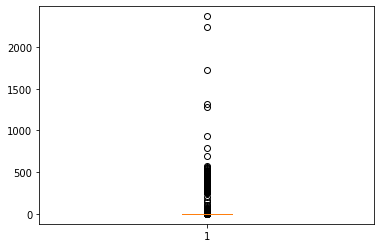

In [0]:
plt.boxplot(PMF_table_5h.IPTW)

In [0]:
PMF_table_5h.IPTW.mean()

1.9061062325406484

In [0]:
X = PMF_table_5h[['tr_t_min_1', 'age', 'female', 	'oasis',	'elixhauser',	'explicit_sepsis',	'vaso']]
y = PMF_table_5h['death_t']

# Instantiate a binomial family model with the logit function.
MSM_model = sm.GLM(y, X, family = sm.families.Binomial(), links = sm.genmod.families.links.logit, freq_weights=PMF_table_5h.IPTW.astype(np.float64))
# MSM_model = sm.GLM(y, X, links = sm.genmod.families.links.logit, freq_weights = MSM_table.IPTW.astype(np.float64))

MSM_result = MSM_model.fit()

print(MSM_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death_t   No. Observations:                50847
Model:                            GLM   Df Residuals:                 96912.78
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6824.5
Date:                Thu, 19 Mar 2020   Deviance:                       13649.
Time:                        17:20:27   Pearson chi2:                 5.23e+05
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
tr_t_min_1          3.4960      0.076     

### 5h and 1%

{'boxes': [<matplotlib.lines.Line2D at 0x7f8baefc3e48>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8baefcc898>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8baefd6358>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8baefccf98>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8baefcc198>,
  <matplotlib.lines.Line2D at 0x7f8baefcc518>]}

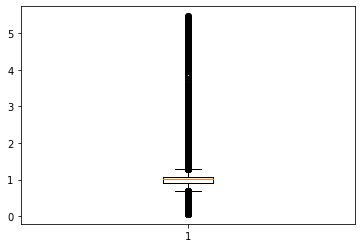

In [0]:
# truncate top 1% and bottom 99% of weights 
MSM_table_trunc_5h = PMF_table_5h[(PMF_table_5h.IPTW < PMF_table_5h.IPTW.quantile(.99)) & (PMF_table_5h.IPTW > PMF_table_5h.IPTW.quantile(.01))]
plt.boxplot(MSM_table_trunc_5h.IPTW)

In [0]:
MSM_table_trunc_5h.IPTW.mean()

0.9903006964851795

In [0]:
X = MSM_table_trunc_5h[['tr_t_min_1', 'age', 'female', 	'oasis',	'elixhauser',	'explicit_sepsis',	'vaso']]
y = MSM_table_trunc_5h['death_t']

# Instantiate a binomial family model with the logit function.
MSM_model = sm.GLM(y, X, family = sm.families.Binomial(), links = sm.genmod.families.links.logit, freq_weights=MSM_table_trunc_5h.IPTW.astype(np.float64))
# MSM_model = sm.GLM(y, X, links = sm.genmod.families.links.logit, freq_weights = MSM_table.IPTW.astype(np.float64))

MSM_result = MSM_model.fit()

print(MSM_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death_t   No. Observations:                49829
Model:                            GLM   Df Residuals:                 49338.69
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1974.2
Date:                Thu, 19 Mar 2020   Deviance:                       3948.4
Time:                        17:22:49   Pearson chi2:                 1.12e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
tr_t_min_1         -0.3292      0.292     

### 5h and 2%

{'boxes': [<matplotlib.lines.Line2D at 0x7f8baef91358>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8baef91d68>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8baef9a828>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8baef9a4a8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8baef91668>,
  <matplotlib.lines.Line2D at 0x7f8baef919e8>]}

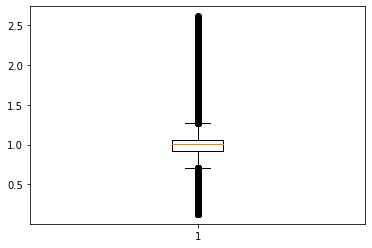

In [0]:
# truncate top 2% and bottom 2% of weights 
MSM_table_trunc_5h_2 = PMF_table_5h[(PMF_table_5h.IPTW < PMF_table_5h.IPTW.quantile(.98)) & (PMF_table_5h.IPTW > PMF_table_5h.IPTW.quantile(.02))]
plt.boxplot(MSM_table_trunc_5h_2.IPTW)

In [0]:
MSM_table_trunc_5h_2.IPTW.mean()

0.9703363853027978

In [0]:
X = MSM_table_trunc_5h_2[['tr_t_min_1', 'age', 'female', 	'oasis',	'elixhauser',	'explicit_sepsis',	'vaso']]
y = MSM_table_trunc_5h_2['death_t']

# Instantiate a binomial family model with the logit function.
MSM_model = sm.GLM(y, X, family = sm.families.Binomial(), links = sm.genmod.families.links.logit, freq_weights=MSM_table_trunc_5h_2.IPTW.astype(np.float64))
# MSM_model = sm.GLM(y, X, links = sm.genmod.families.links.logit, freq_weights = MSM_table.IPTW.astype(np.float64))

MSM_result = MSM_model.fit()

print(MSM_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death_t   No. Observations:                48813
Model:                            GLM   Df Residuals:                 47358.03
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1925.6
Date:                Thu, 19 Mar 2020   Deviance:                       3851.2
Time:                        17:23:06   Pearson chi2:                 1.07e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
tr_t_min_1         -0.4215      0.359     